## Prepare data

### Only consider remove outliers

Read all the data. Apply simple outlier removal by validity range.

20240105_164214: 0    Robot not moving, just starting up.
Name: Description, dtype: object



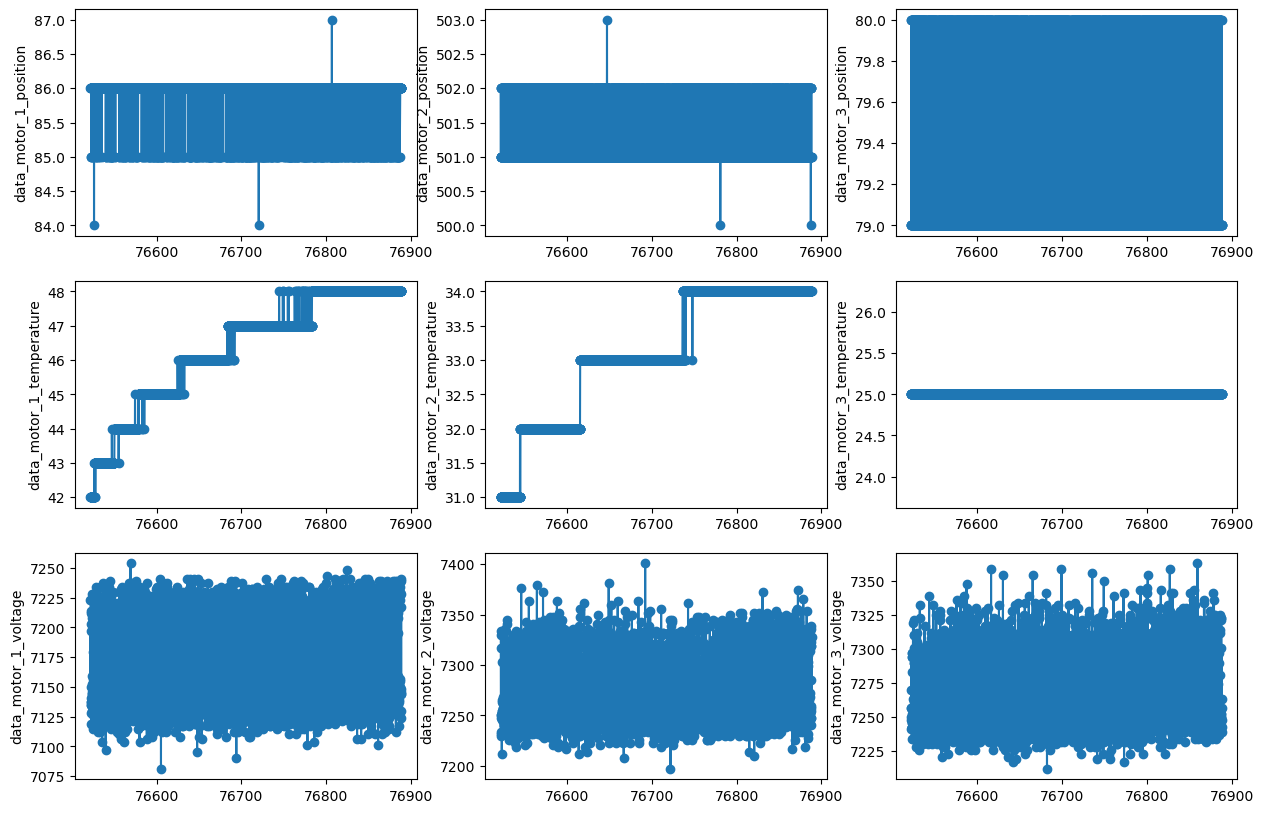

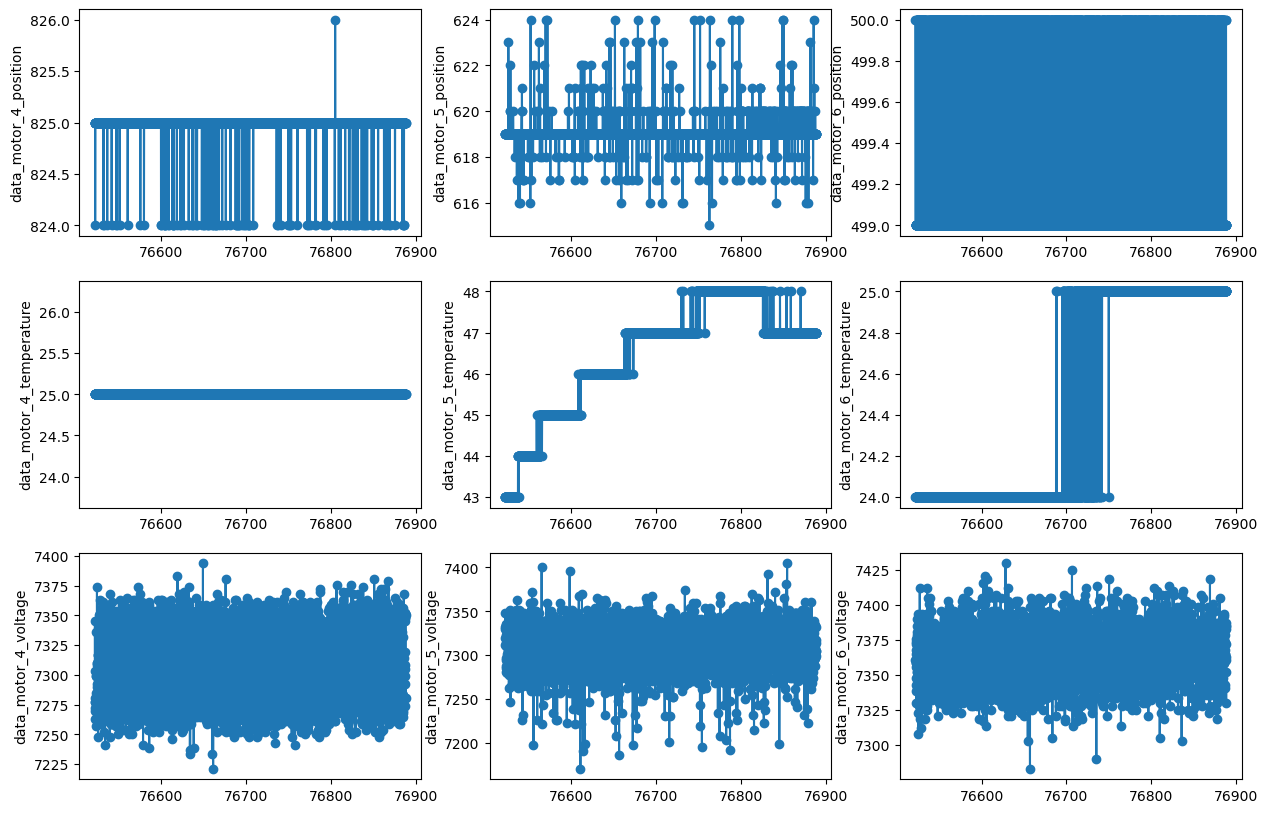

20240105_165300: 1    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



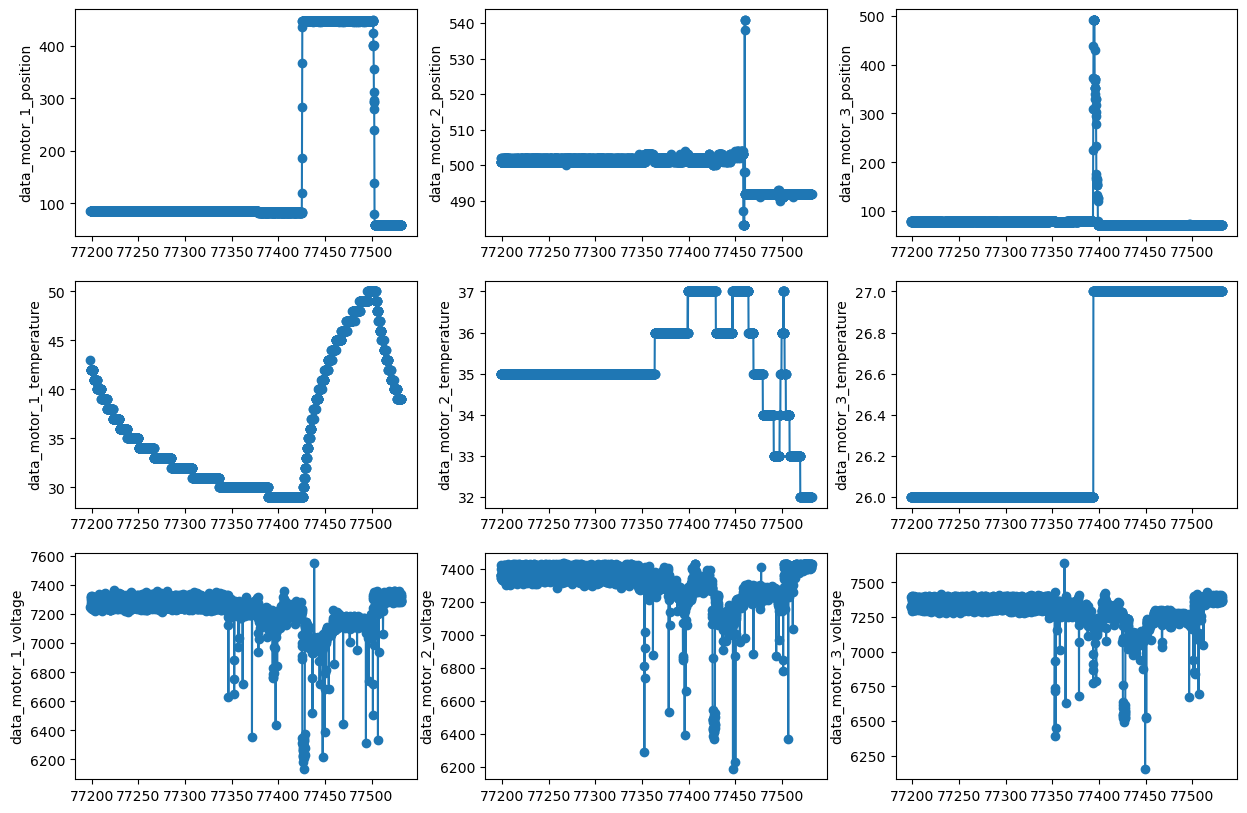

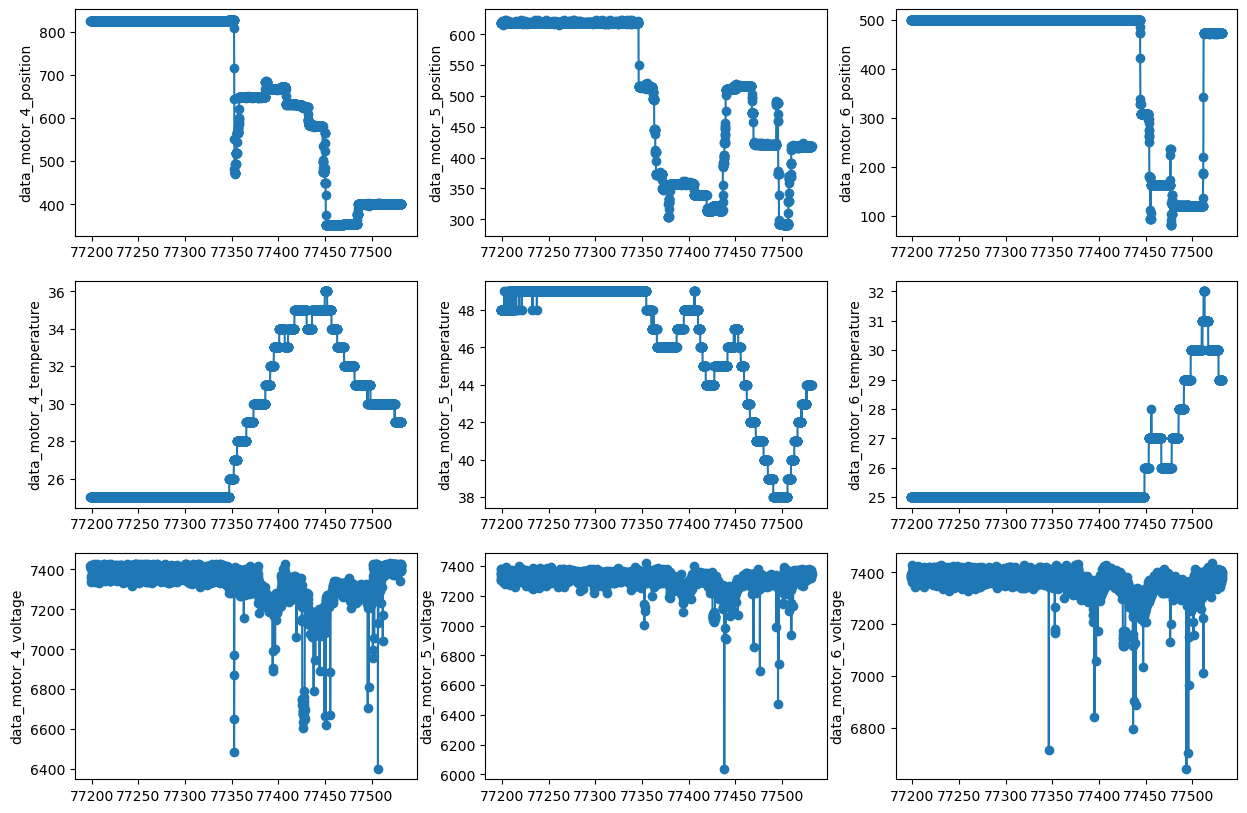

20240105_165972: 2    Not moving. After the operation.
Name: Description, dtype: object



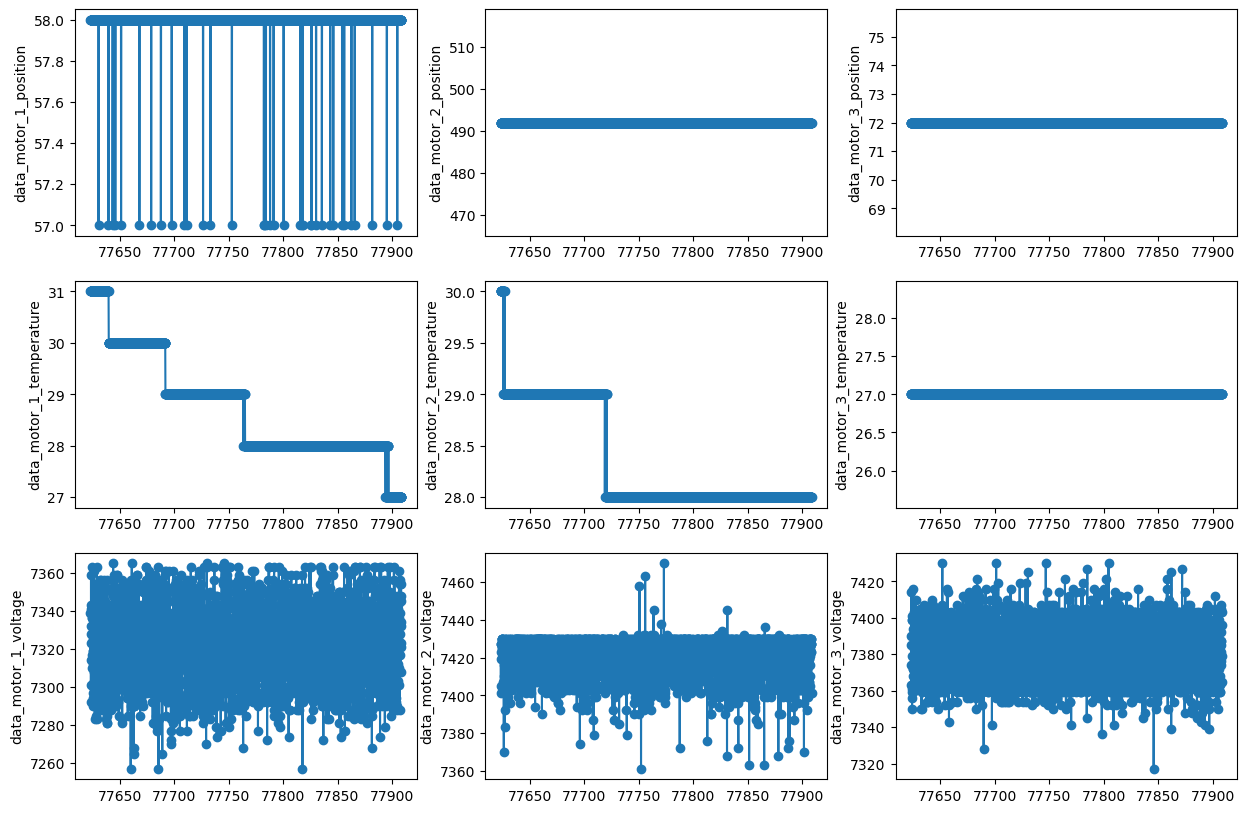

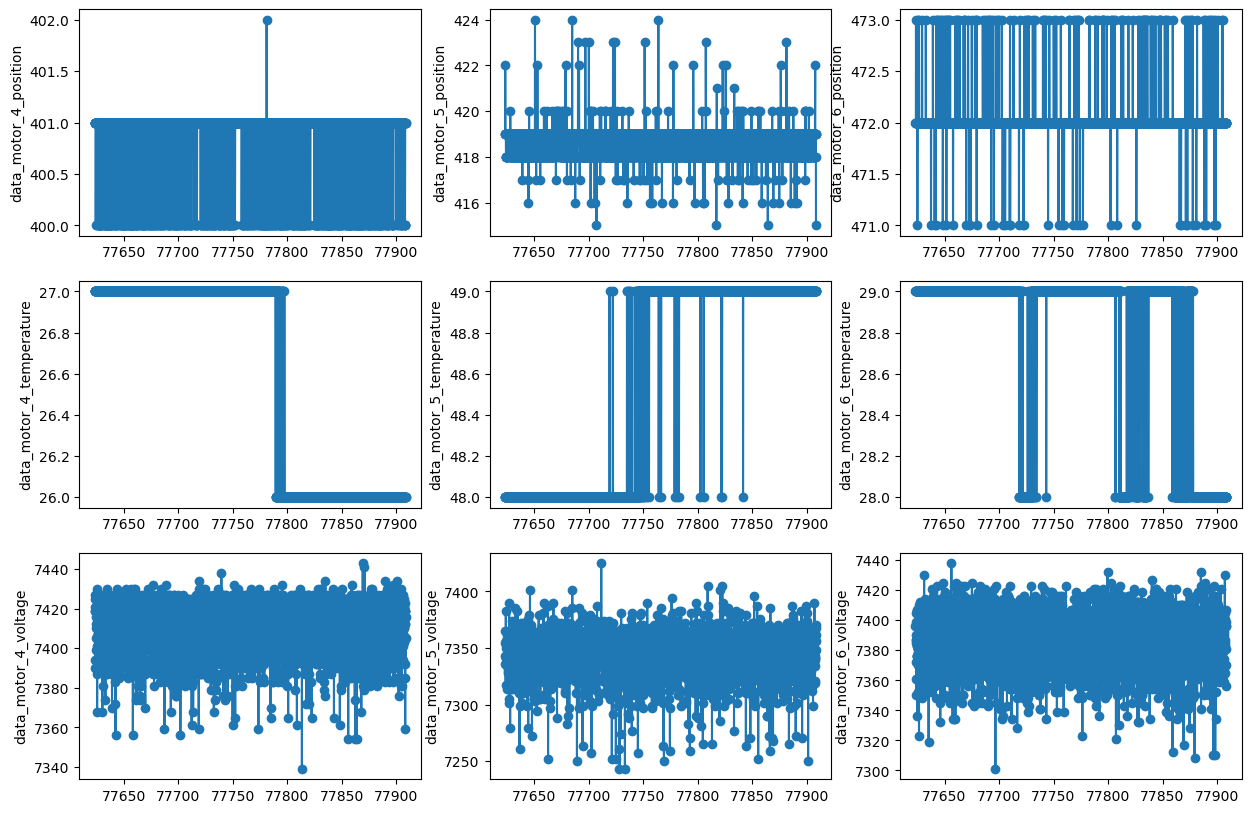

20240320_152031: 3    Robot not moving, just starting up.
Name: Description, dtype: object



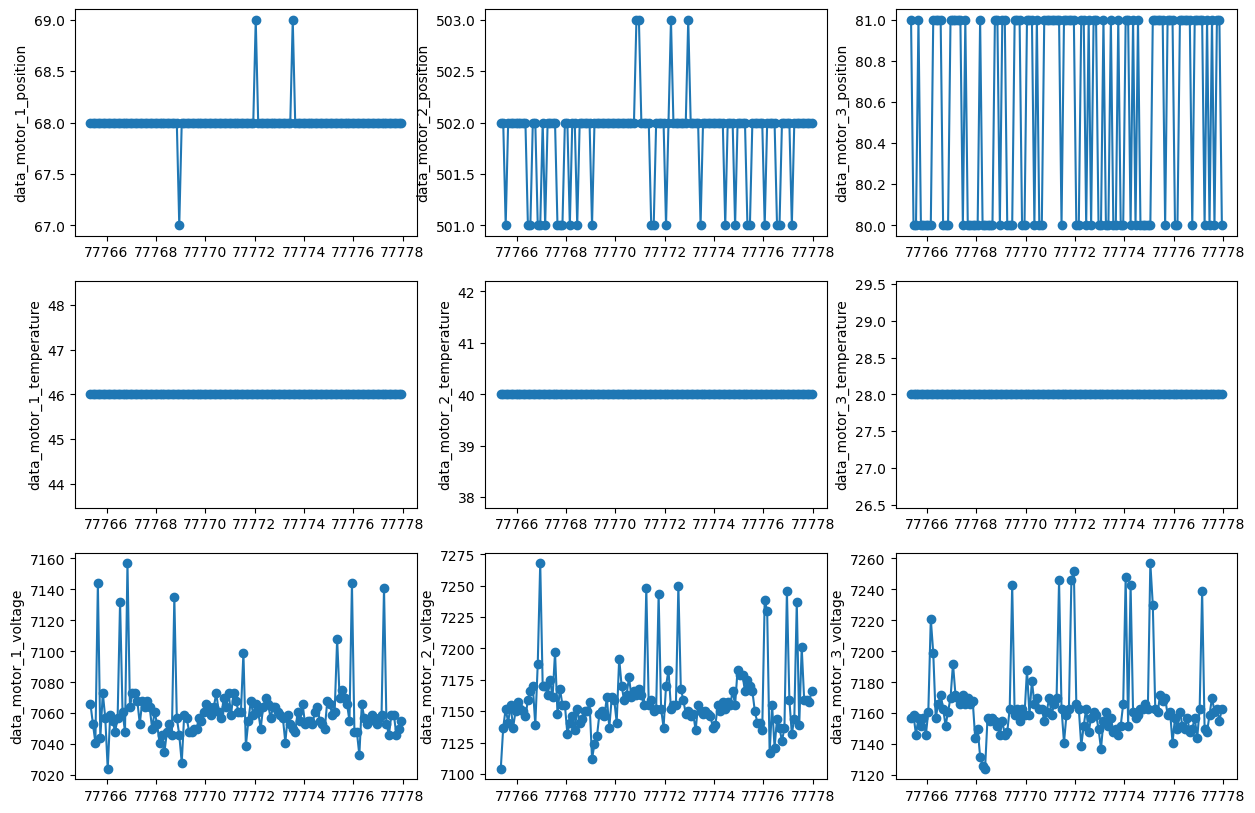

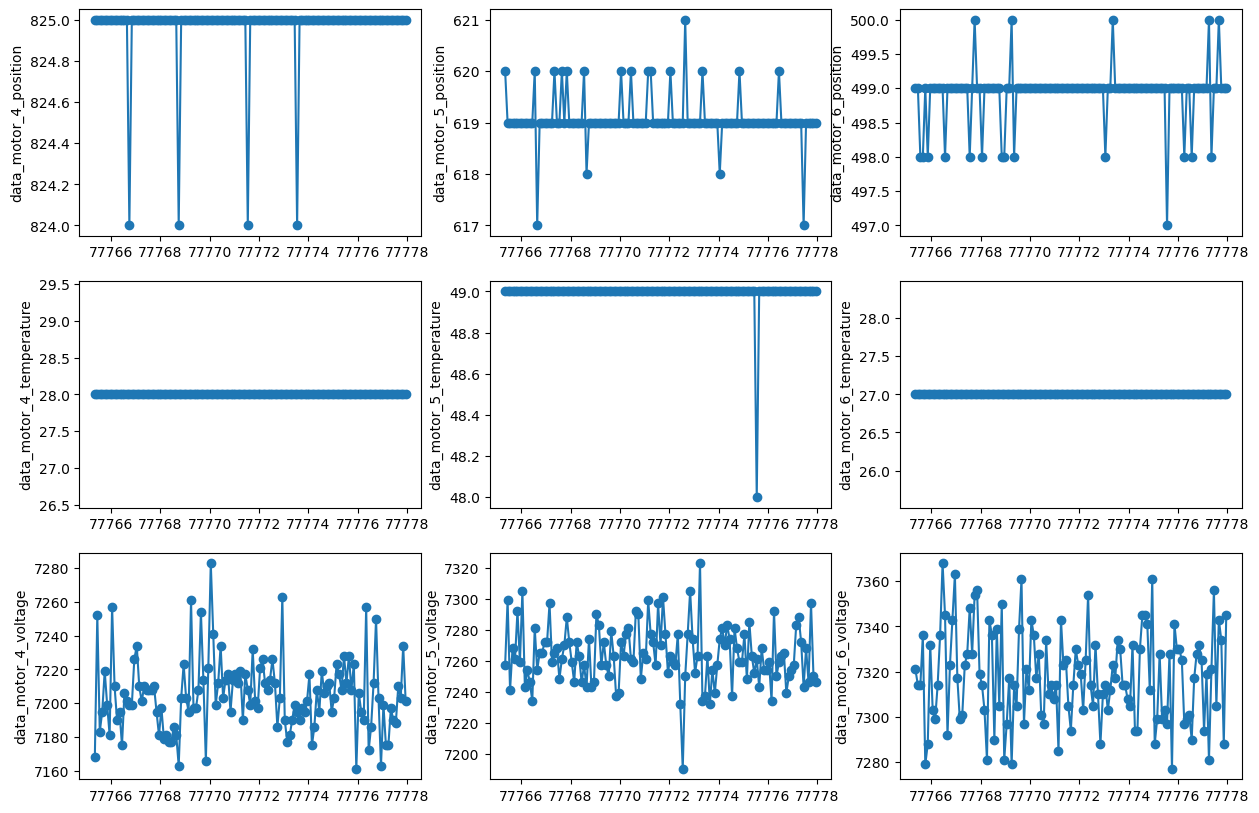

20240320_153841: 4    Not moving. Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



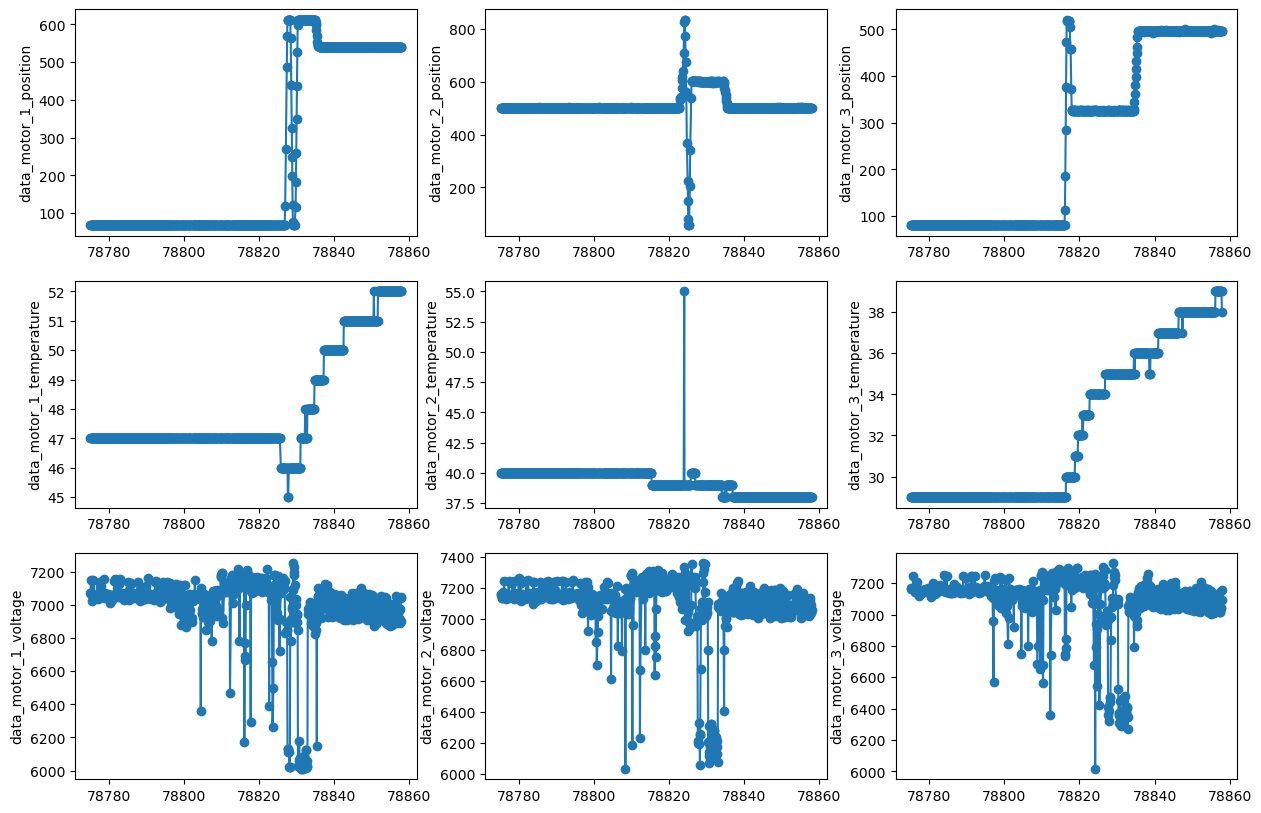

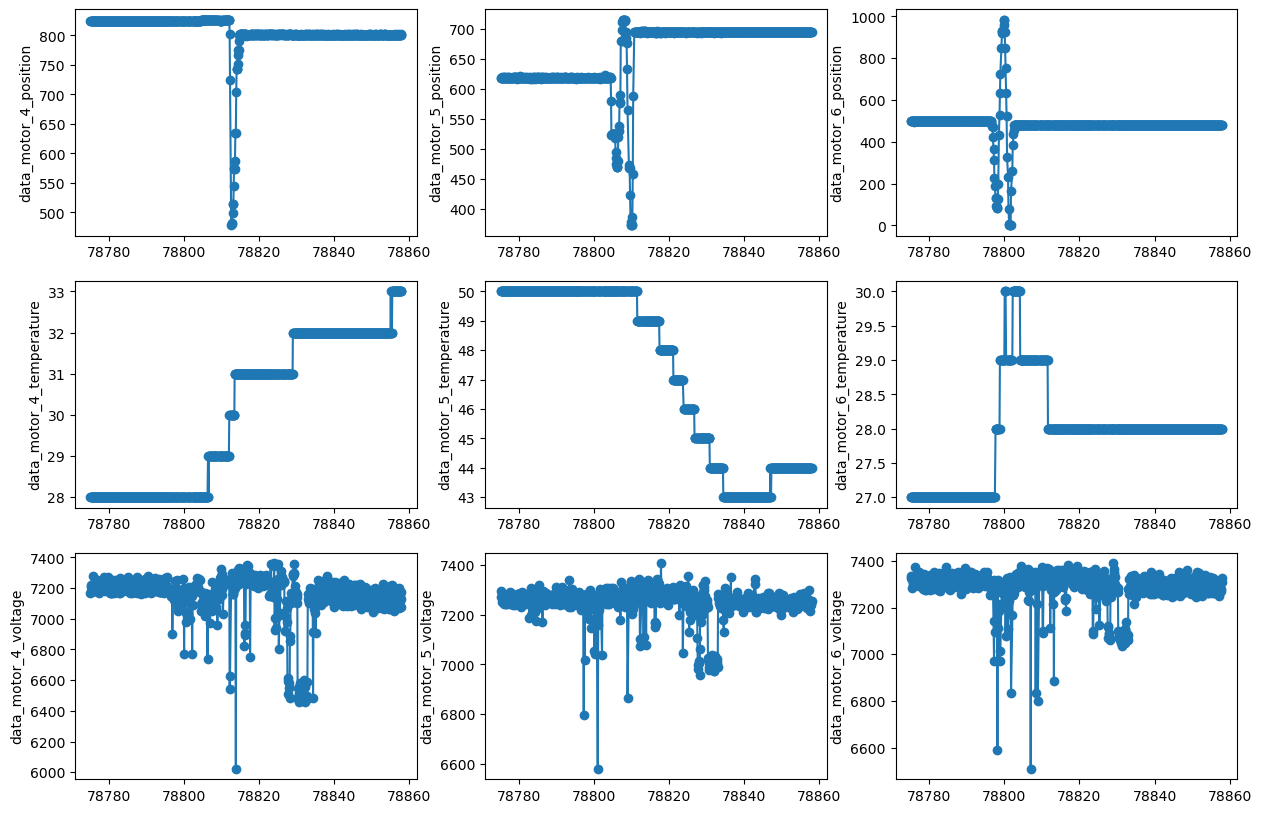

20240320_155664: 5    Robot not moving.
Name: Description, dtype: object



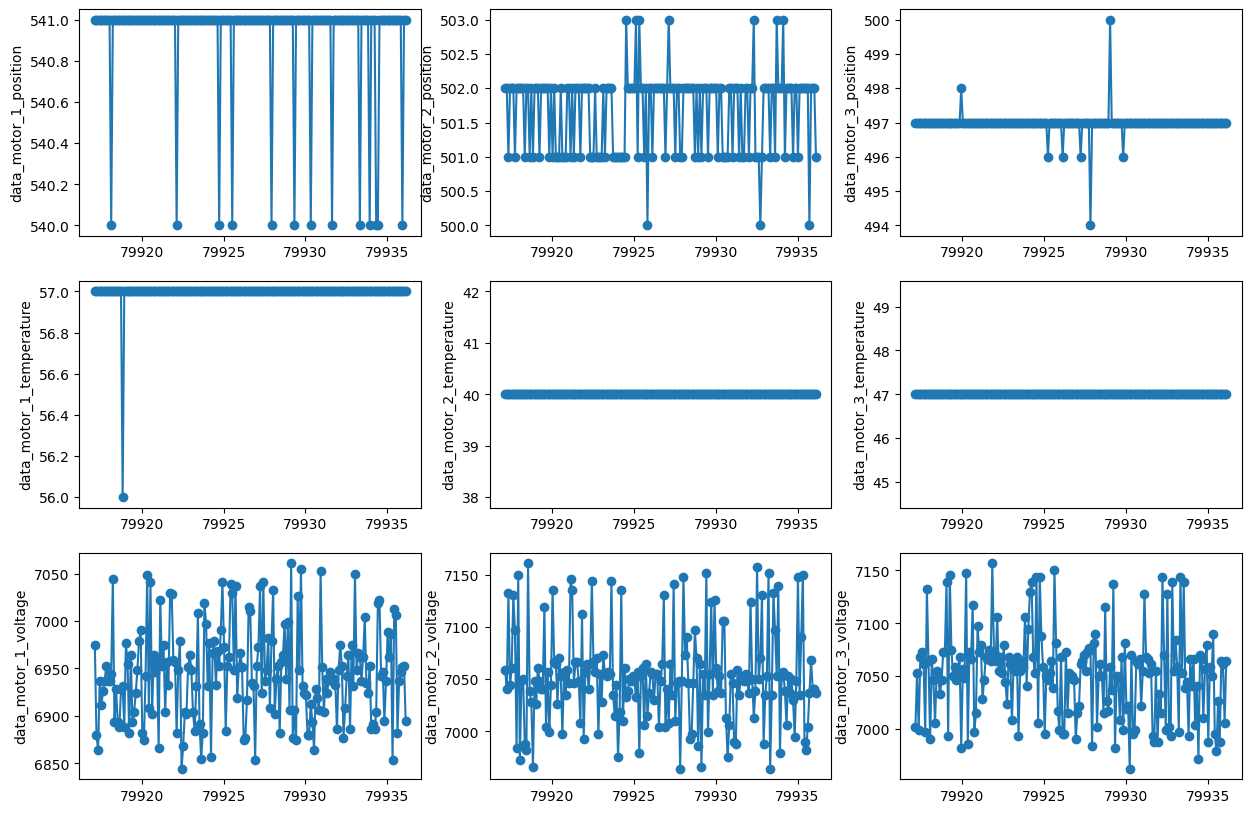

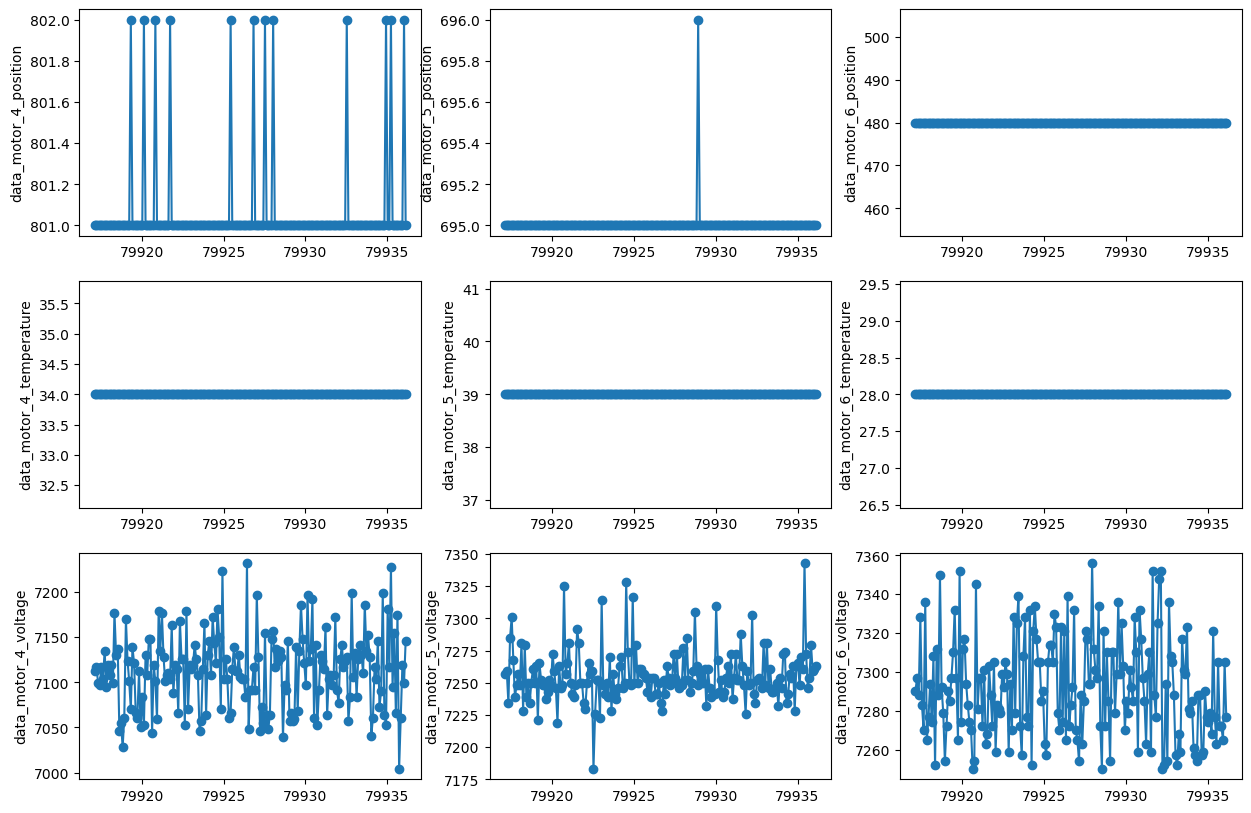

20240321_122650: 6    Try to move to pick up an item from second flo...
Name: Description, dtype: object



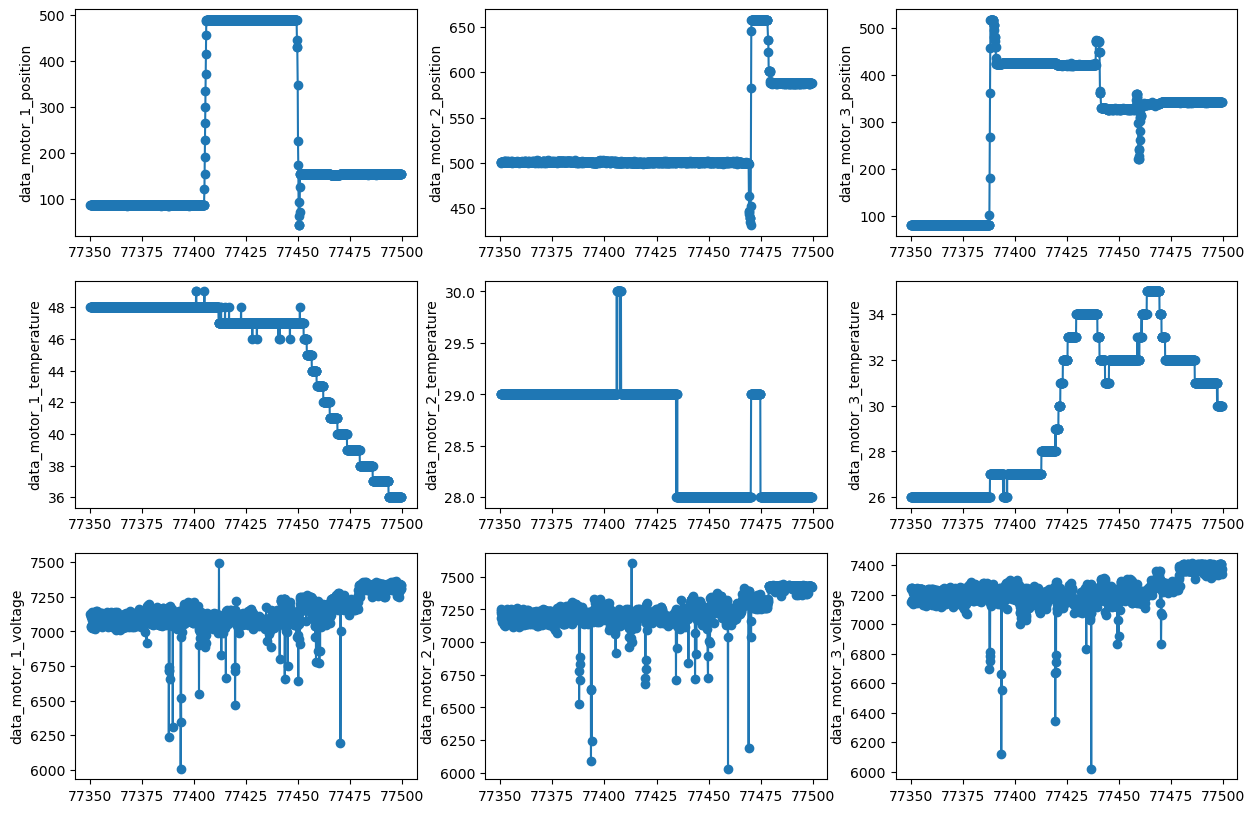

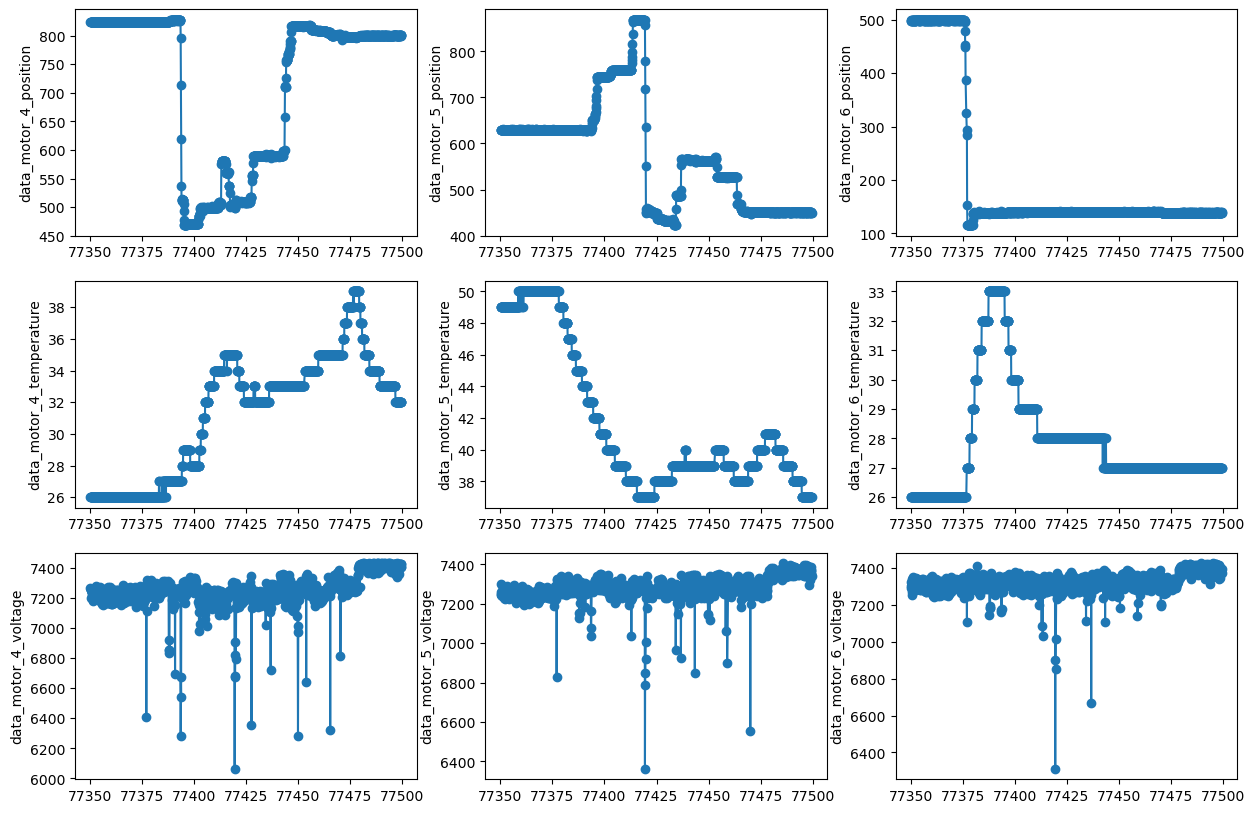

20240325_135213: 7    Robot not moving, just starting up.
Name: Description, dtype: object



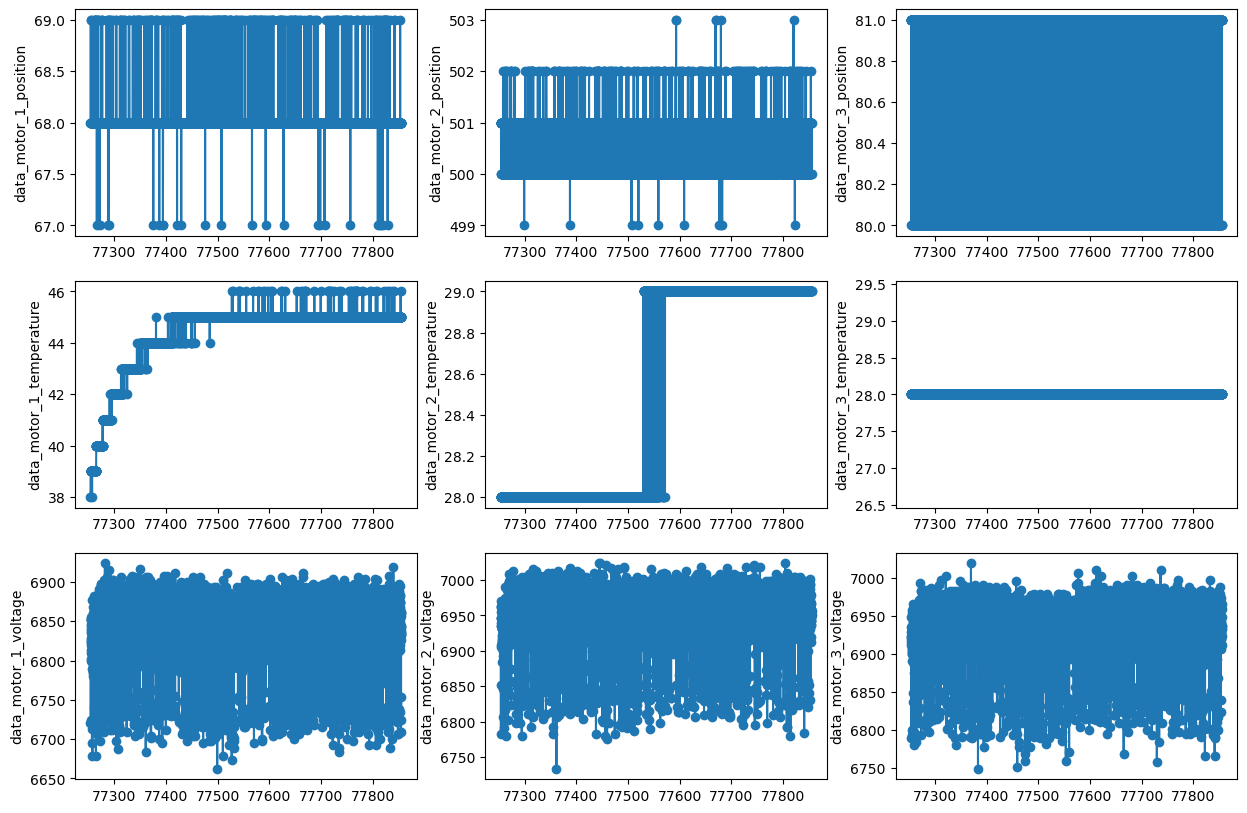

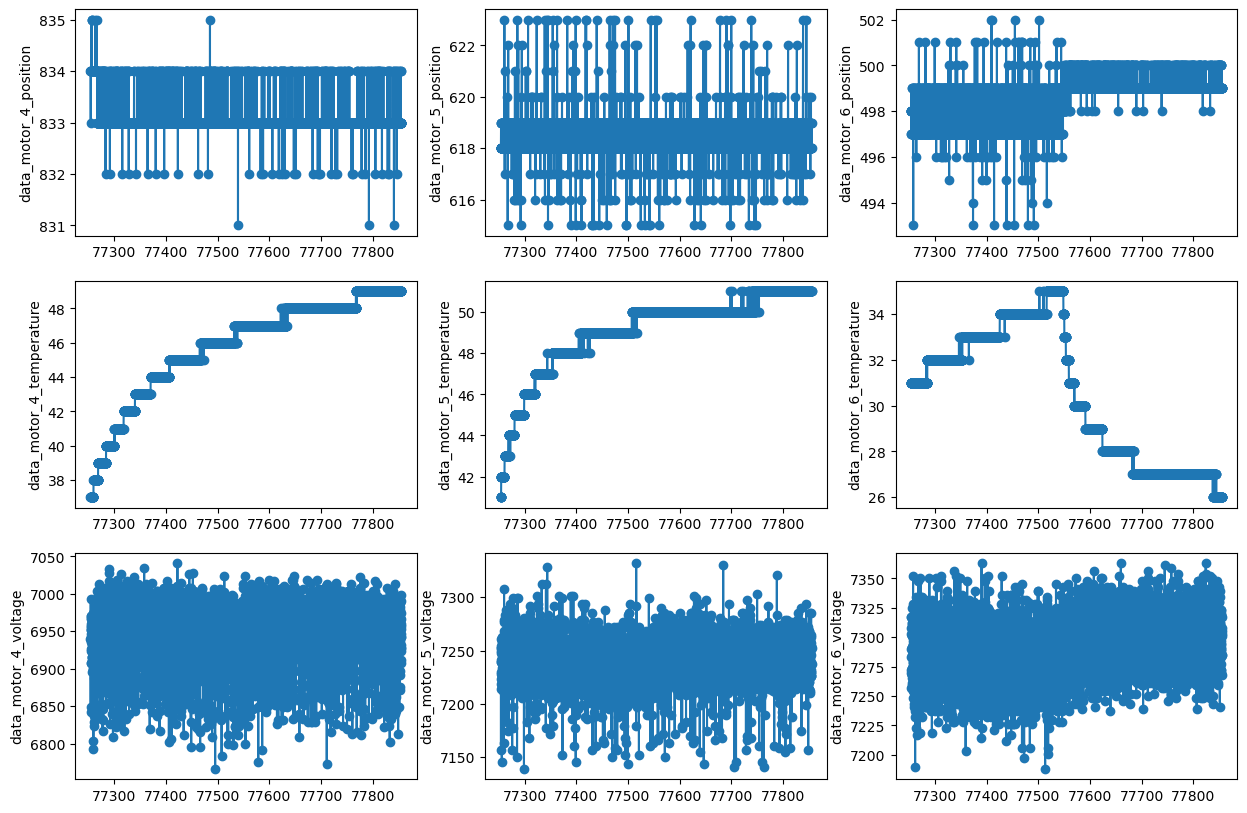

20240325_152902: 8    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



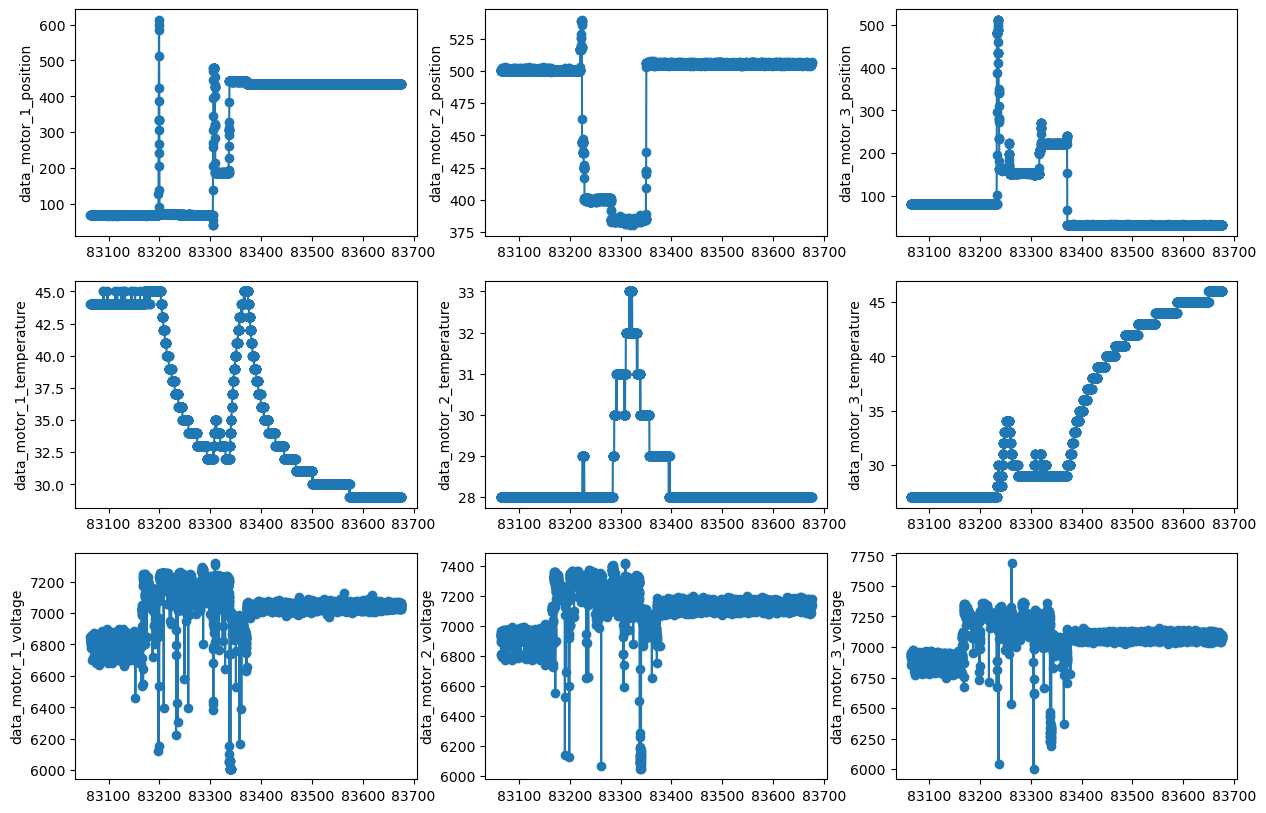

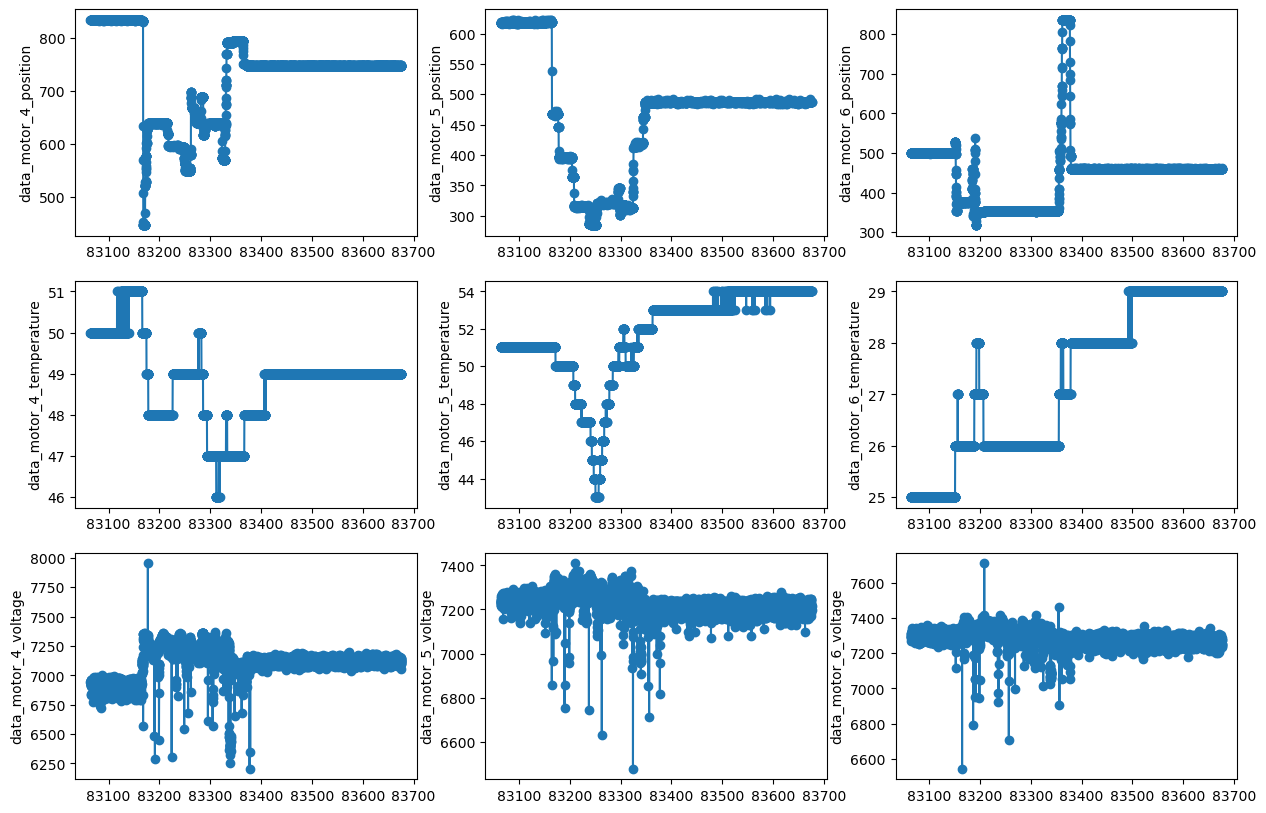

20240325_155003: 9    Starting position: Straigt. Perform two operat...
Name: Description, dtype: object



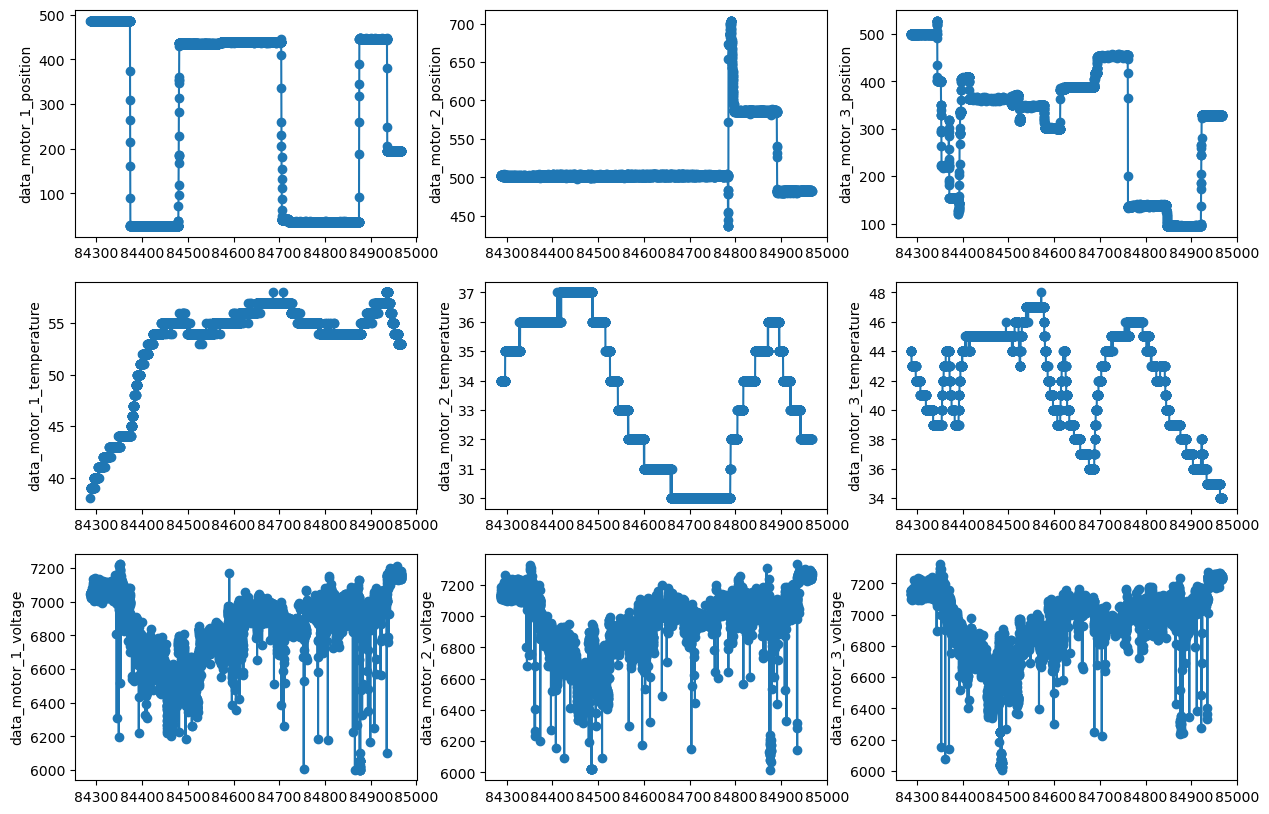

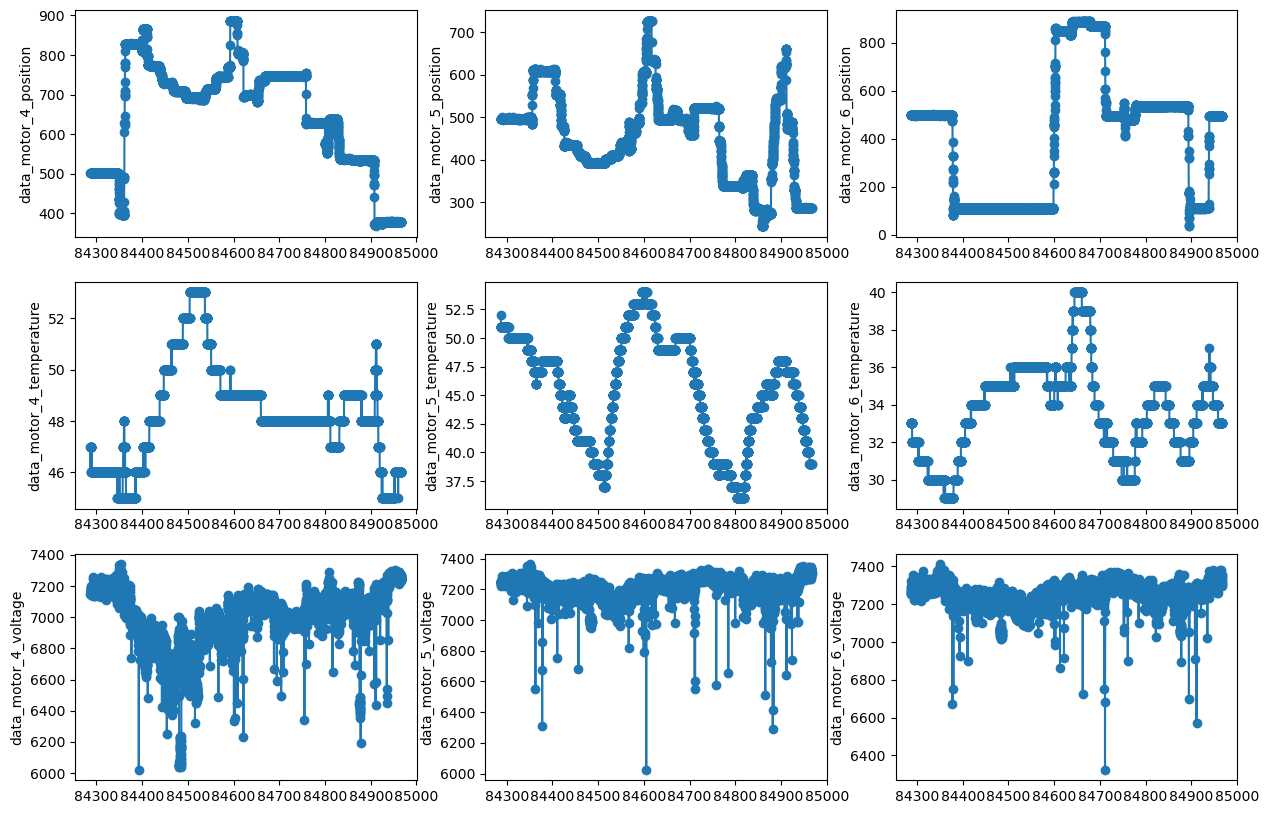

In [1]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../robot_digital_twin/condition_monitoring_matlab_ros/matlab_application/collected_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers)

### Apply smoothing as a preprocessing

It can be seen that we have quite a lot of noise in the data, especitally on the voltage. Let's apply a sliding window smoothing to the remove the potential noise.

20240105_164214: 0    Robot not moving, just starting up.
Name: Description, dtype: object



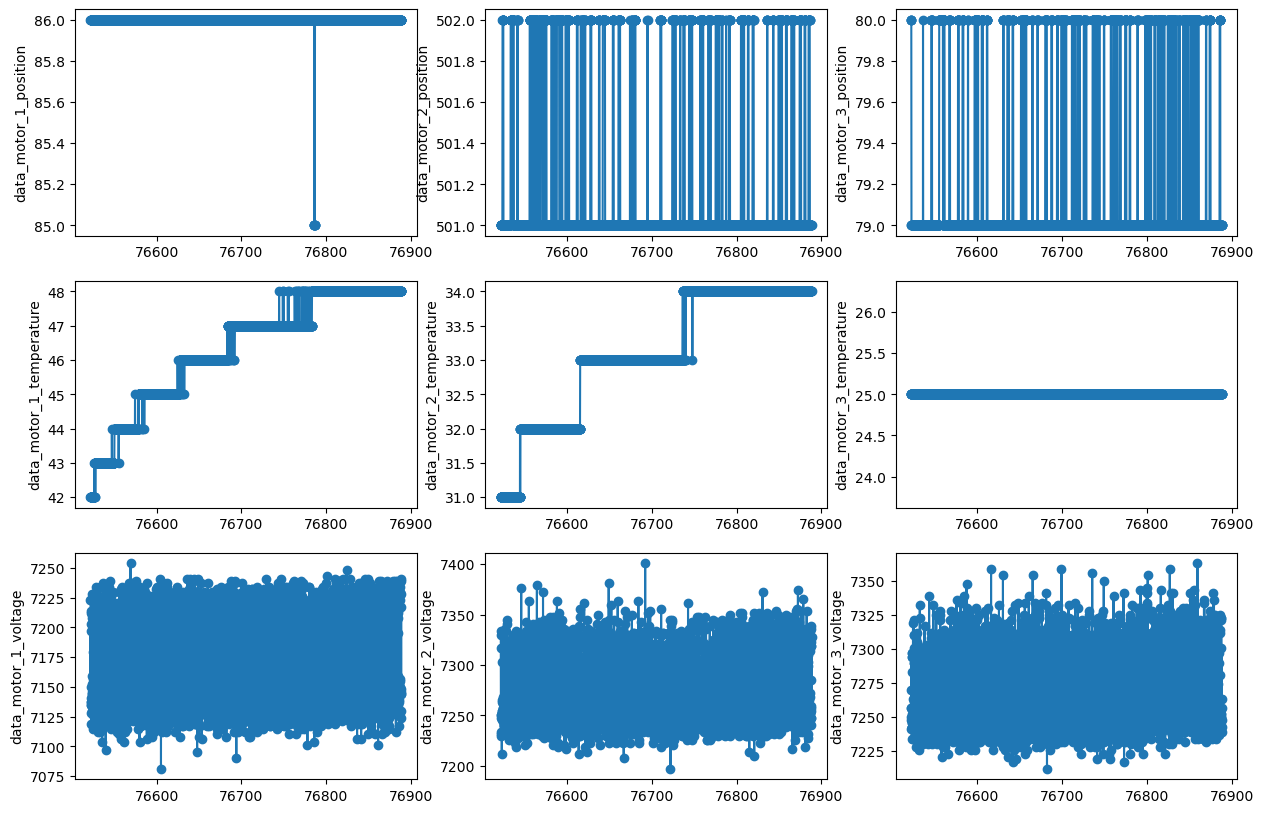

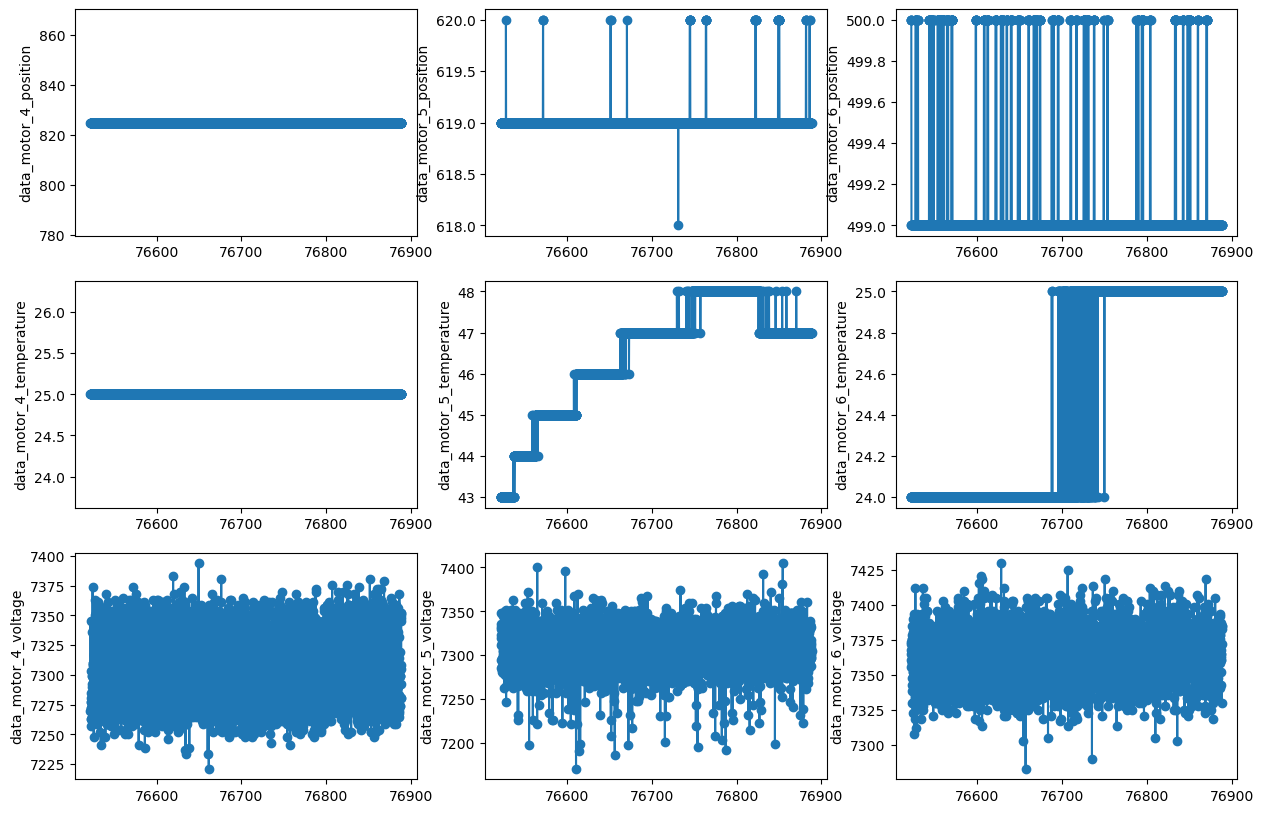

20240105_165300: 1    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



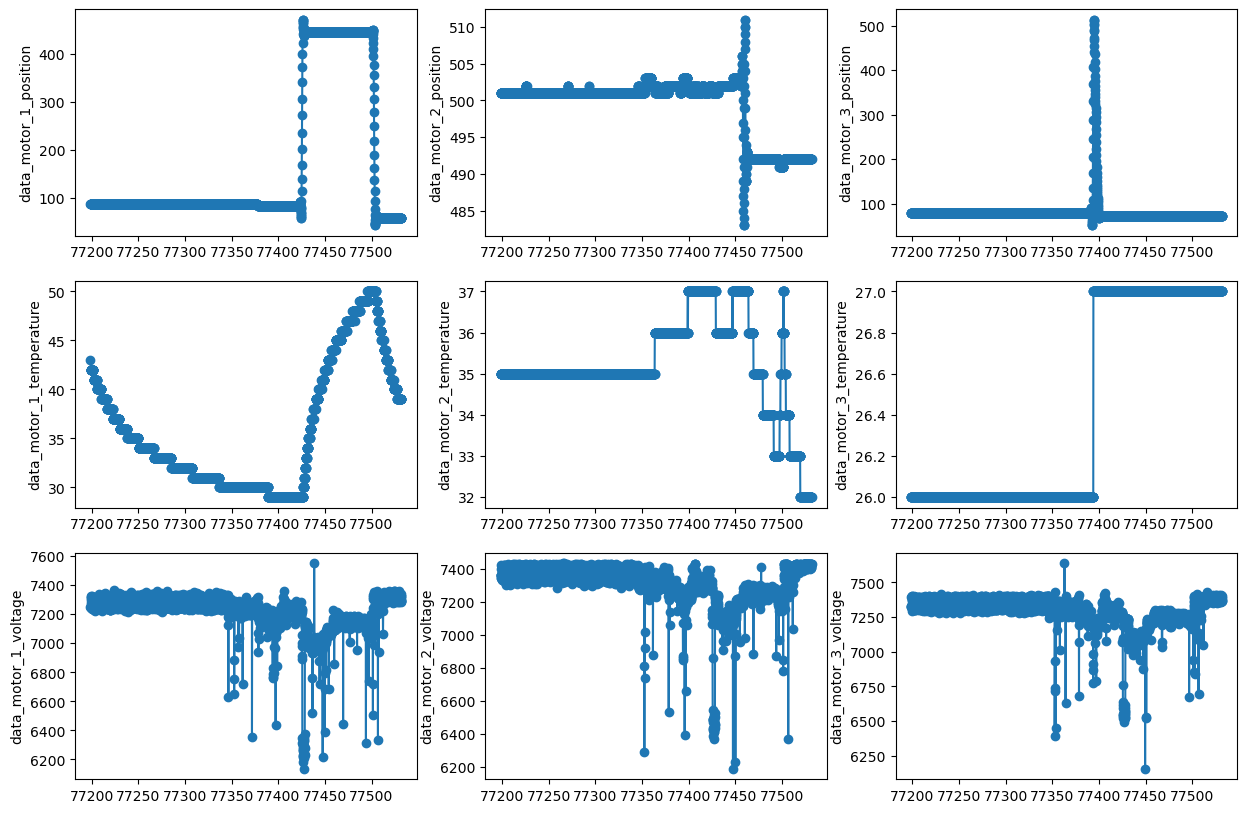

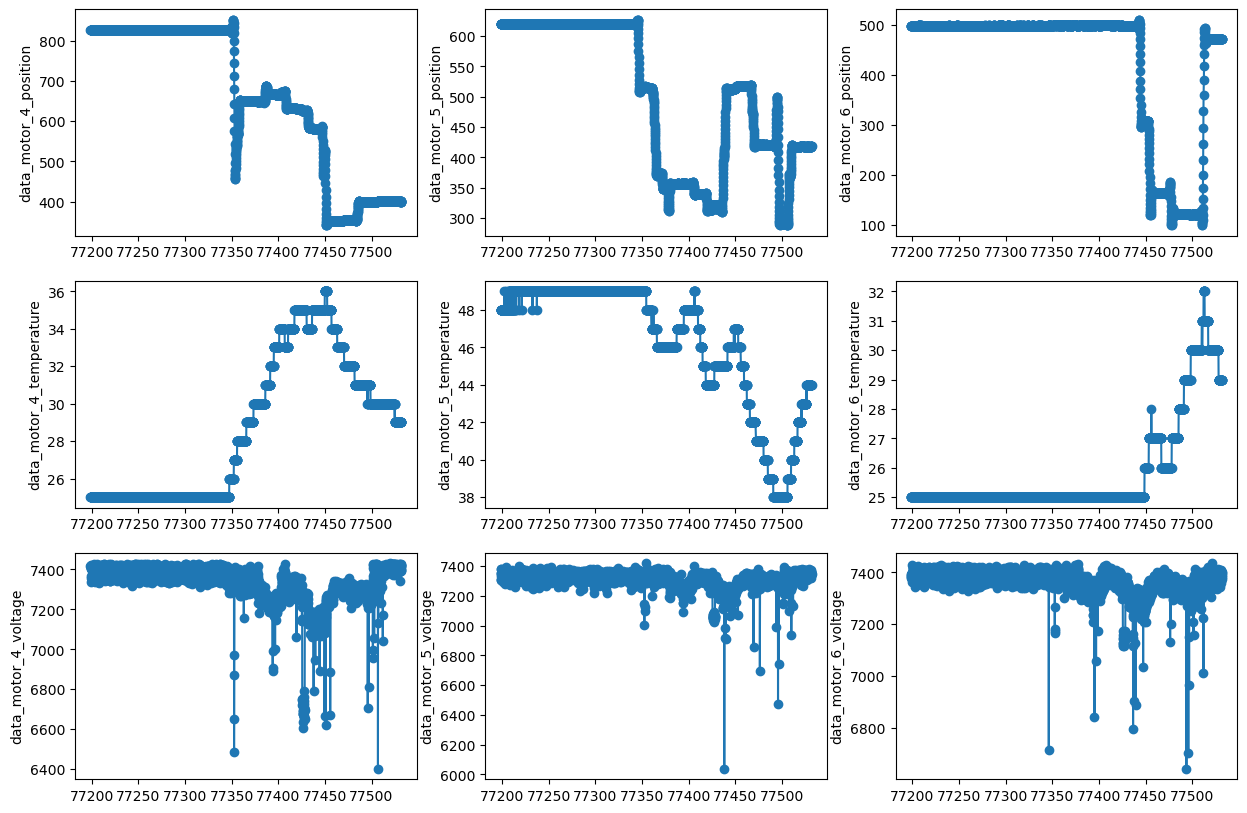

20240105_165972: 2    Not moving. After the operation.
Name: Description, dtype: object



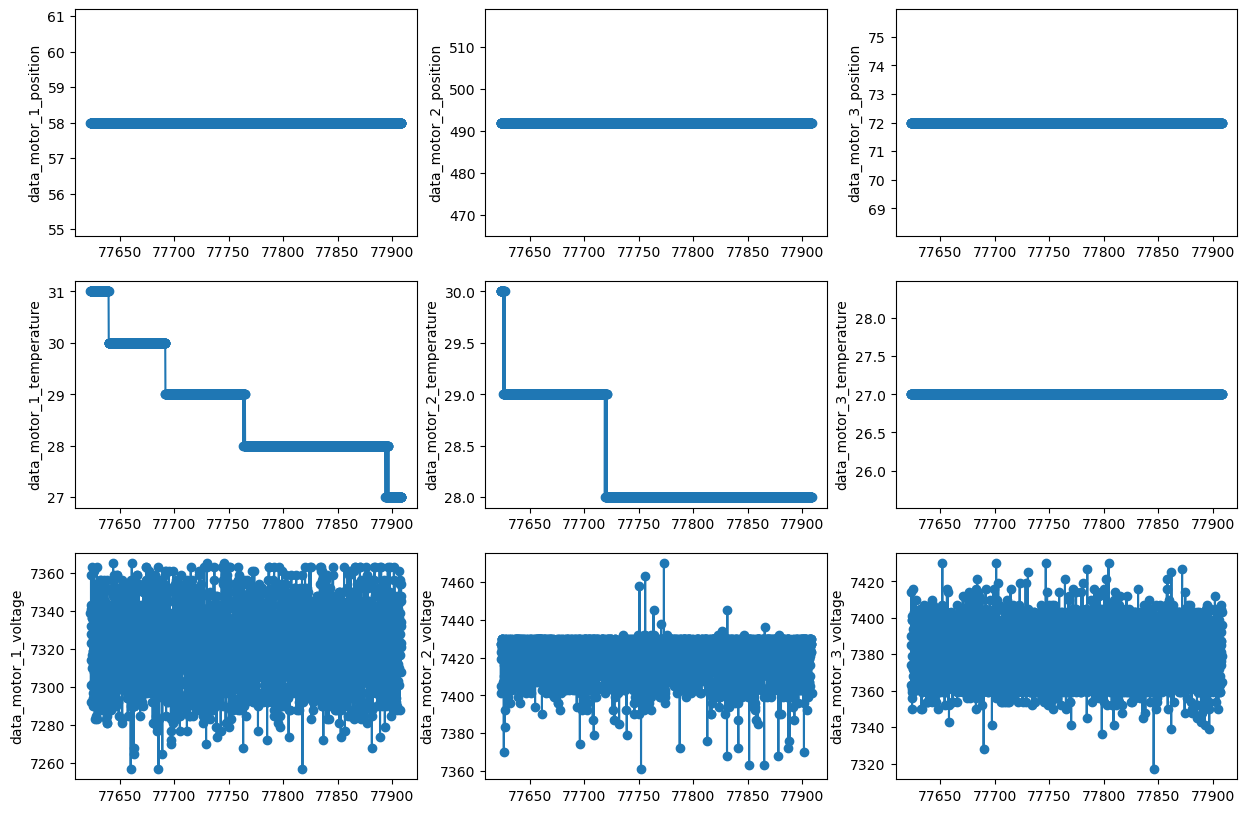

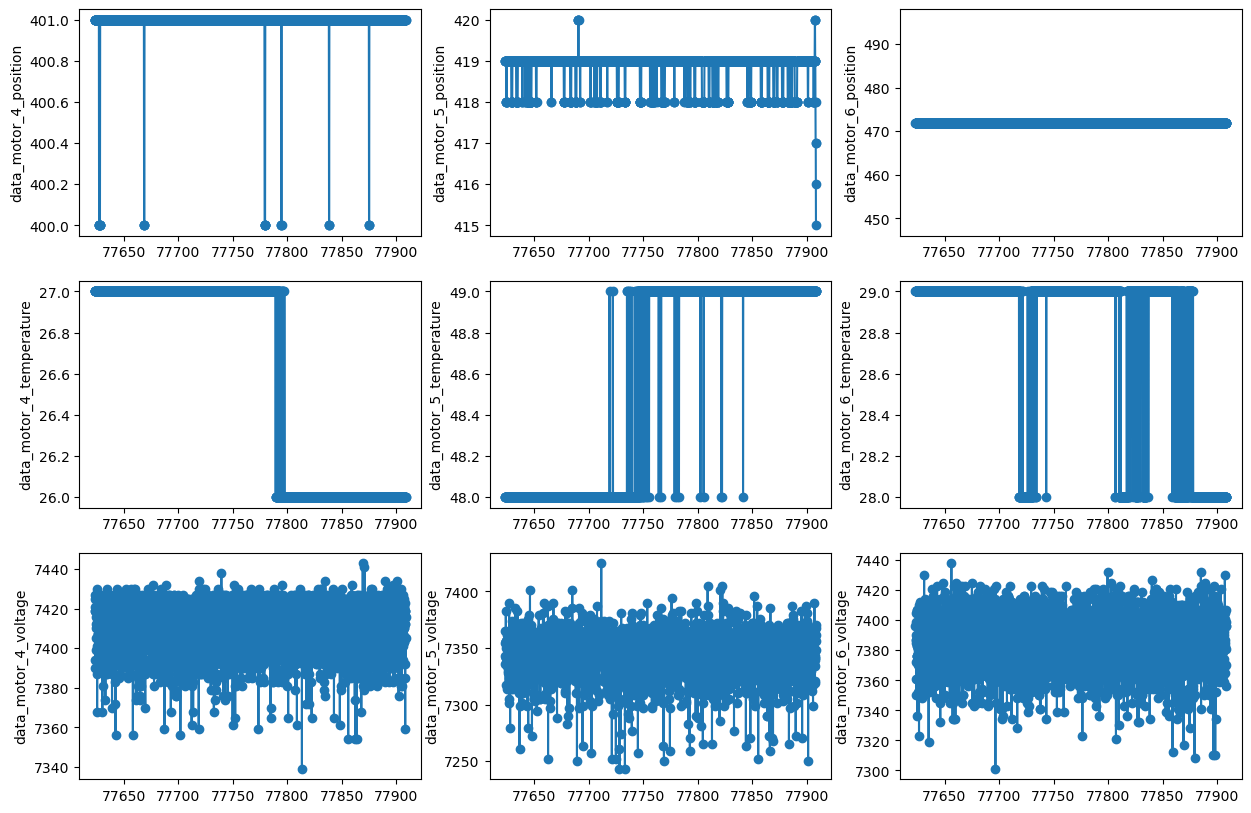

20240320_152031: 3    Robot not moving, just starting up.
Name: Description, dtype: object



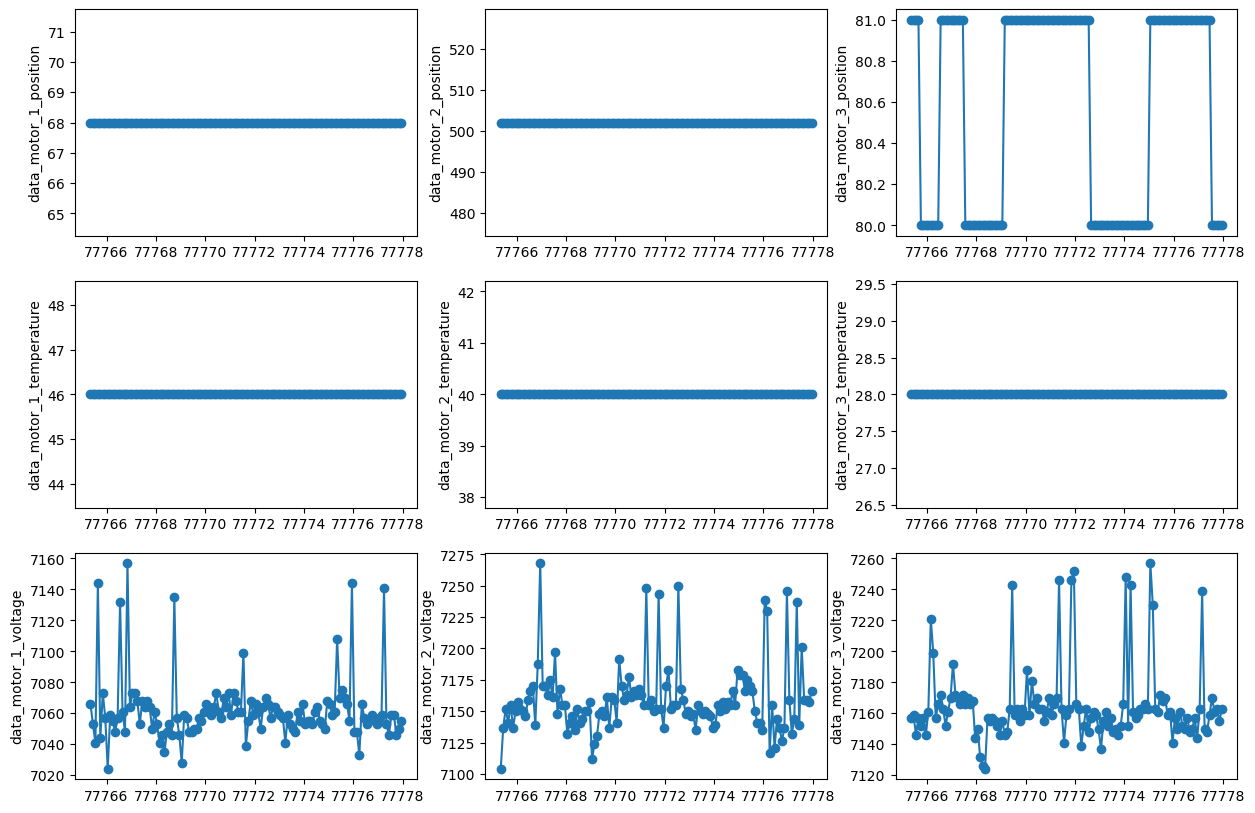

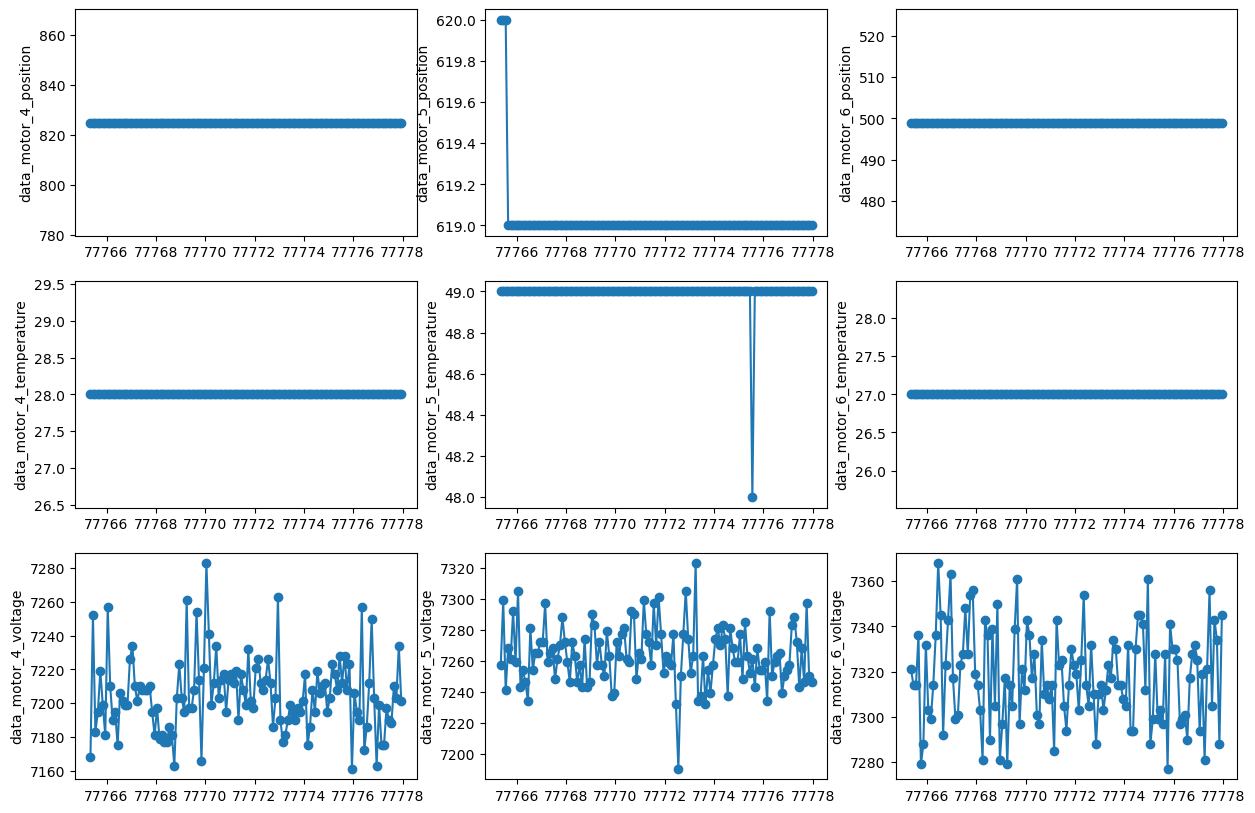

20240320_153841: 4    Not moving. Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



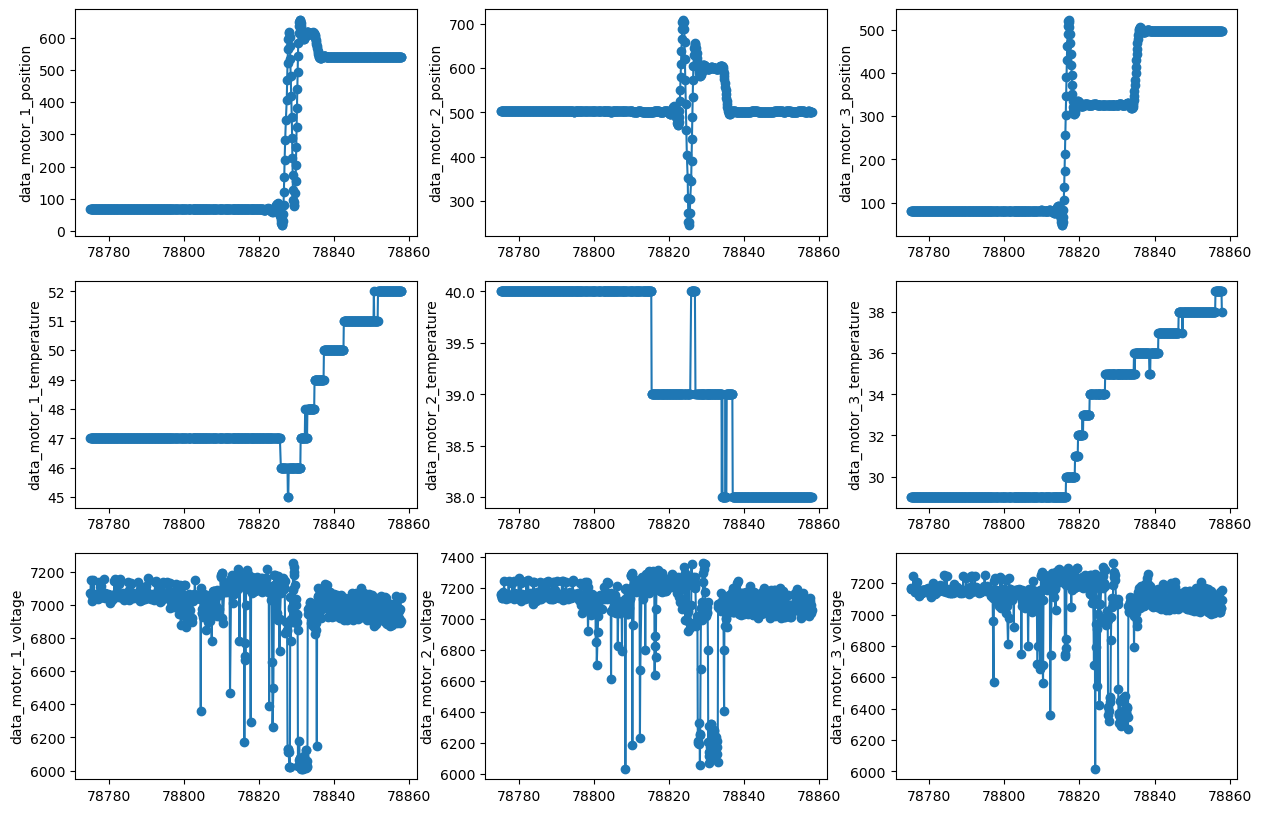

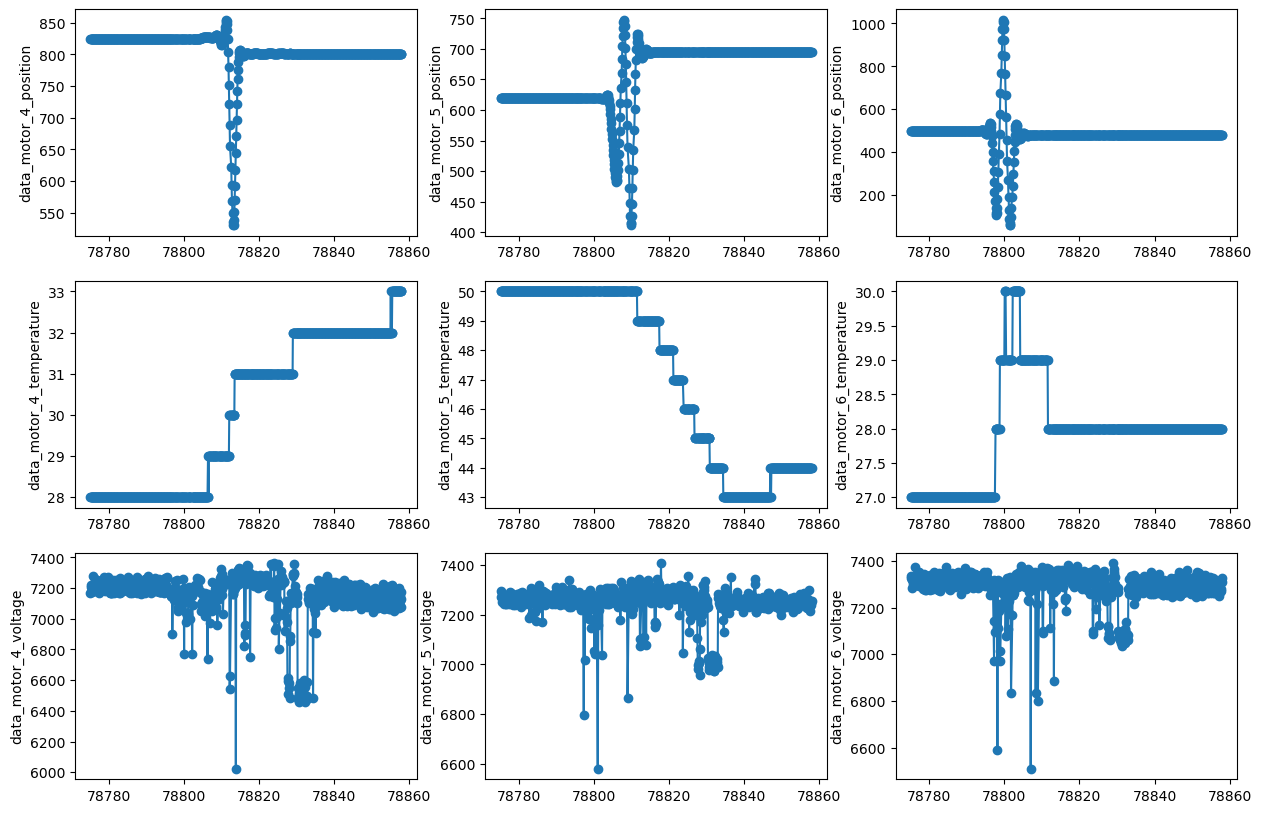

20240320_155664: 5    Robot not moving.
Name: Description, dtype: object



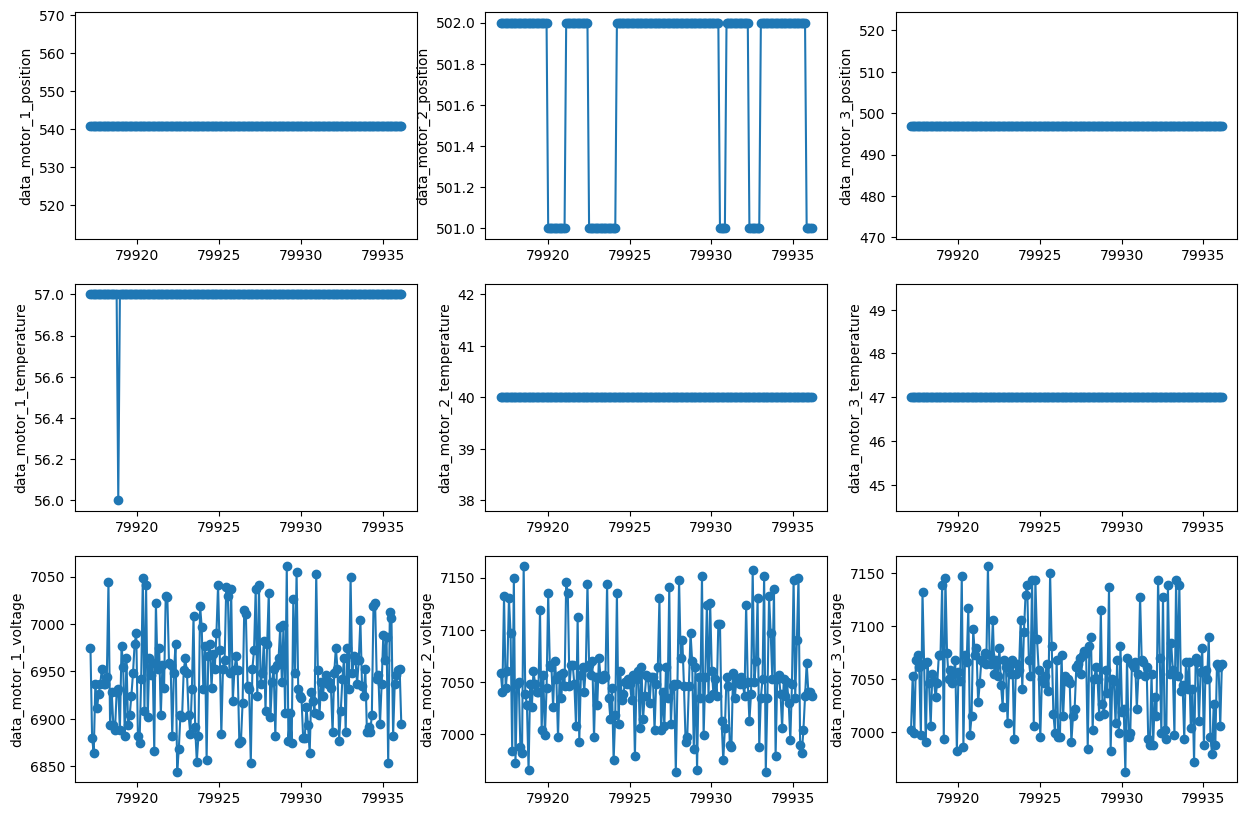

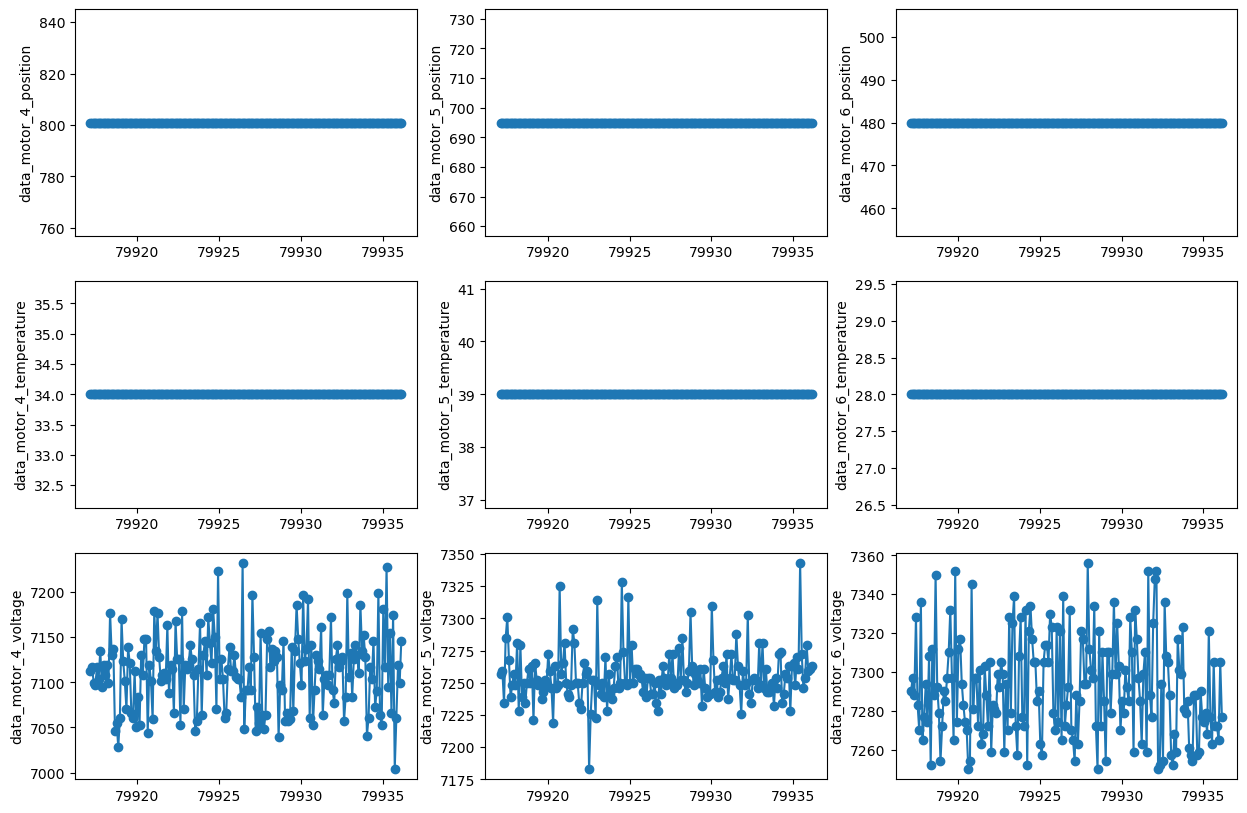

20240321_122650: 6    Try to move to pick up an item from second flo...
Name: Description, dtype: object



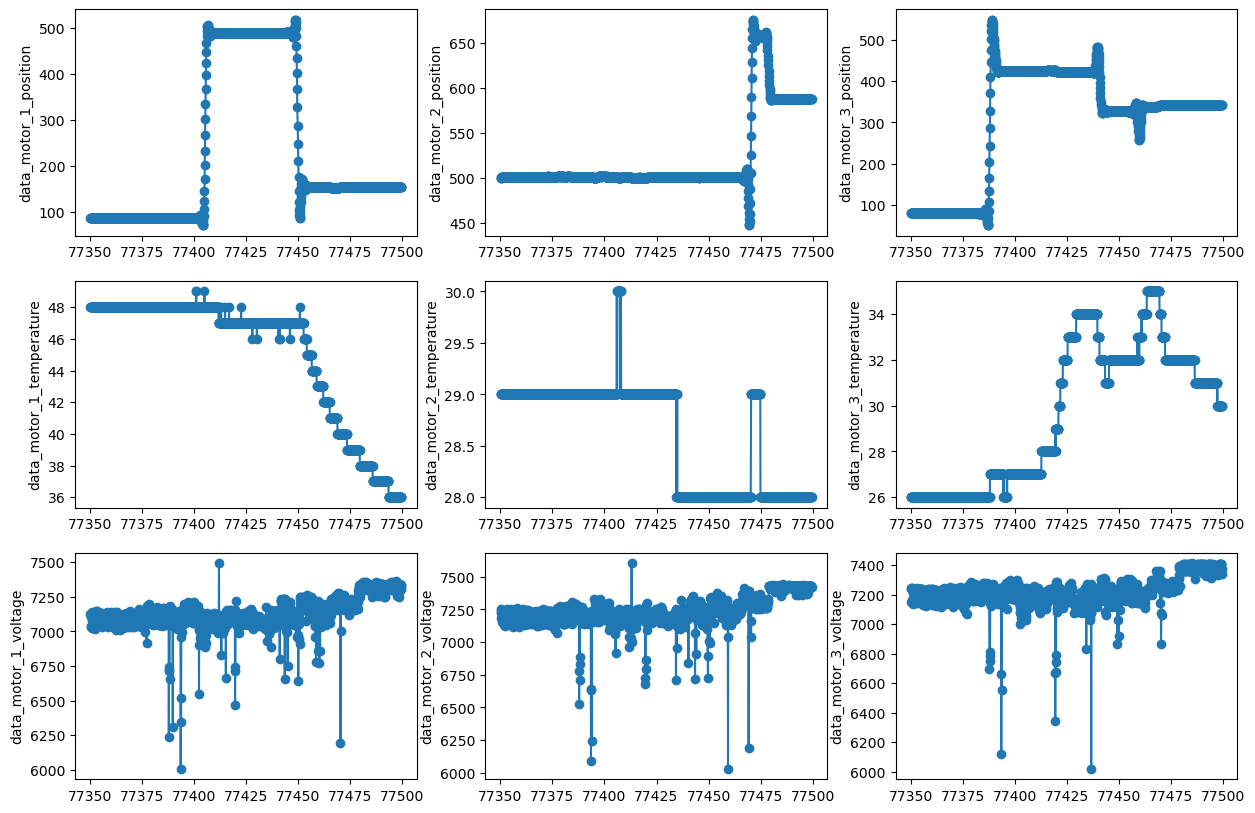

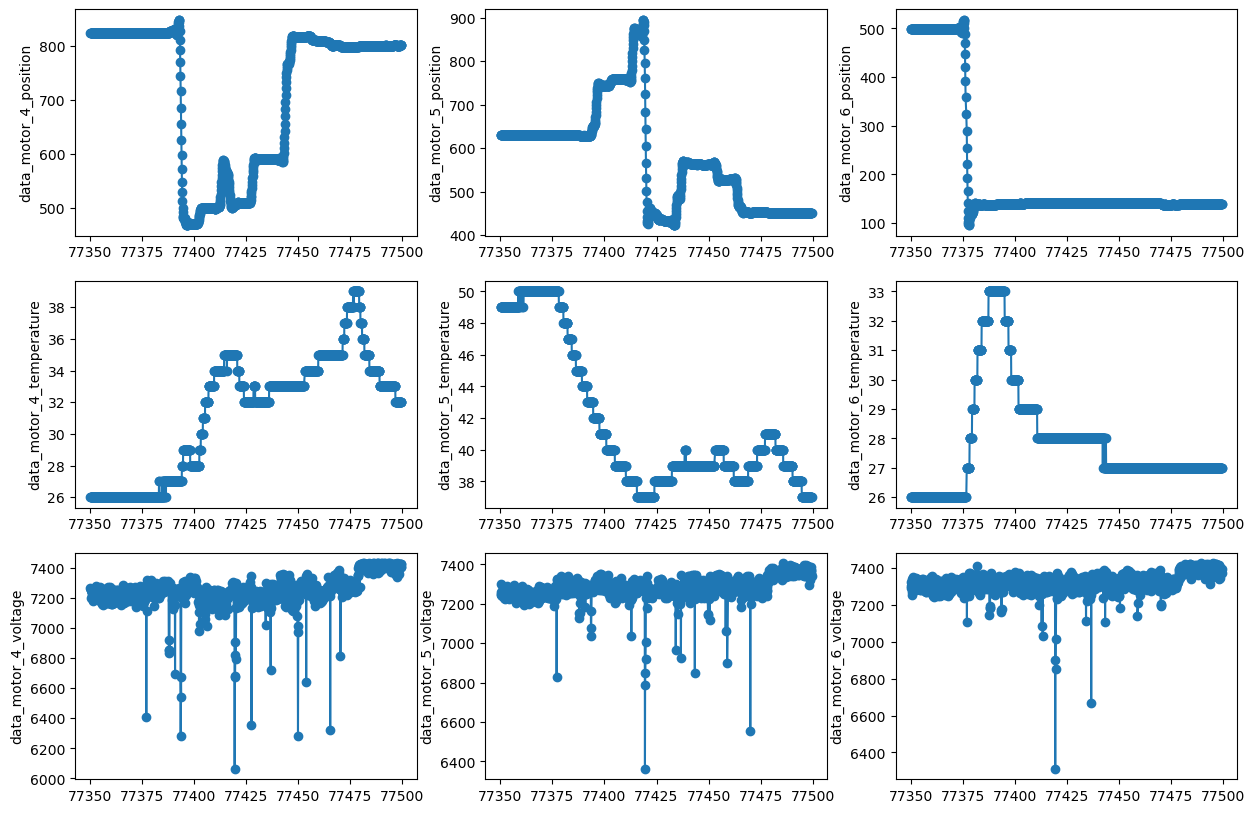

20240325_135213: 7    Robot not moving, just starting up.
Name: Description, dtype: object



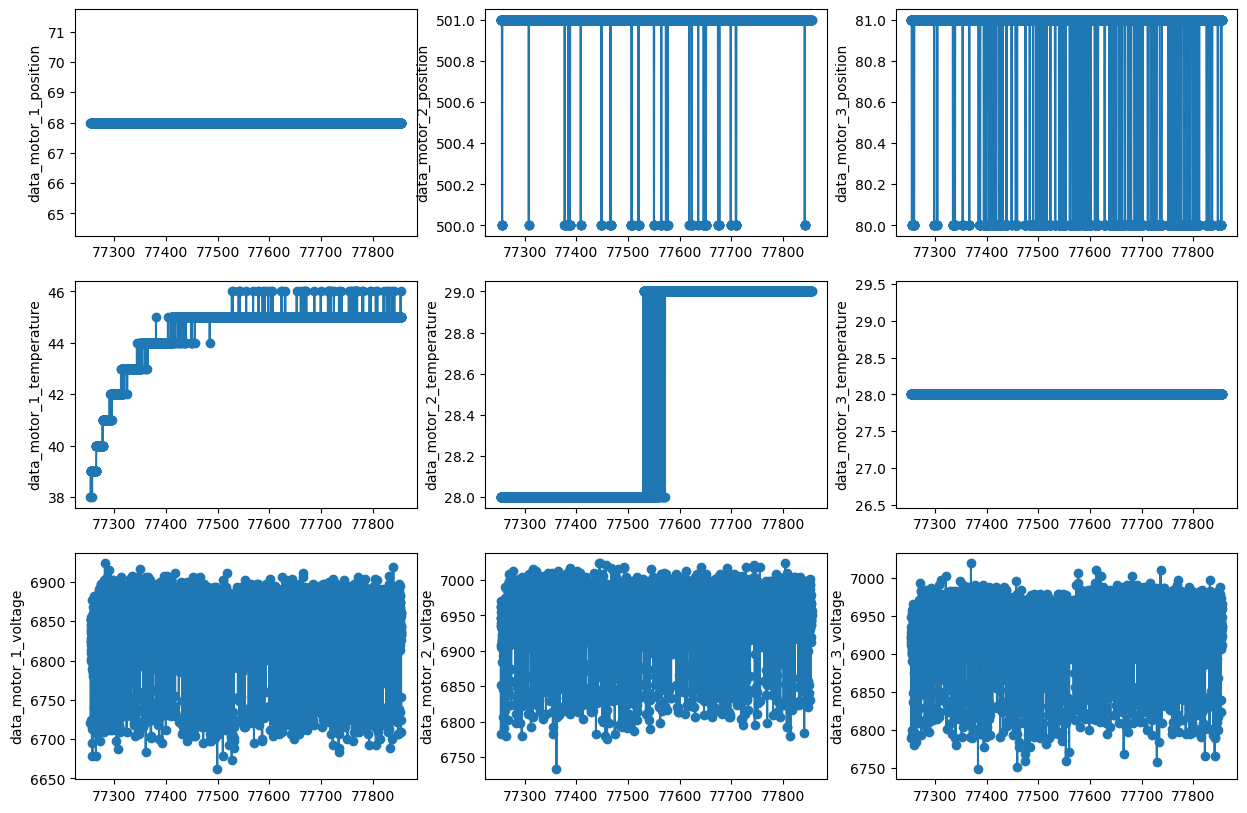

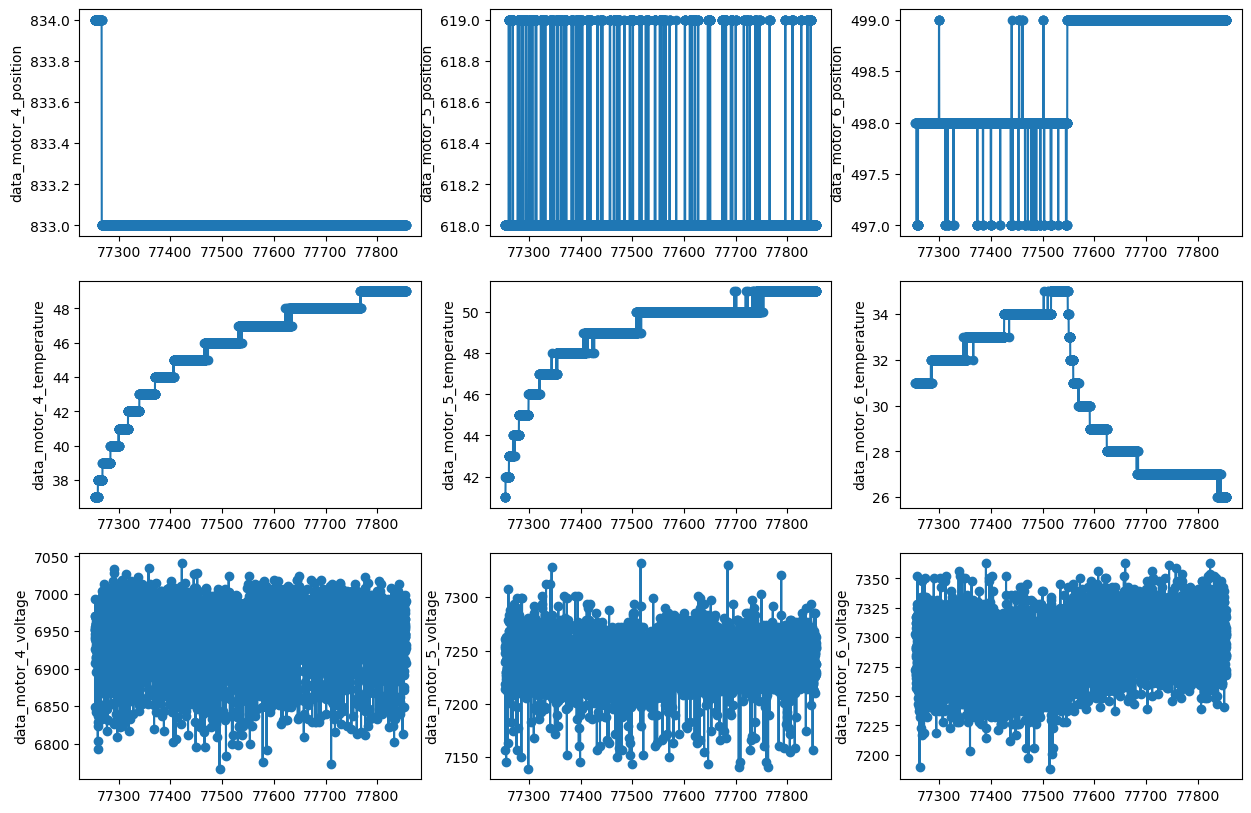

20240325_152902: 8    Not moving. Then perform a pick-up and place o...
Name: Description, dtype: object



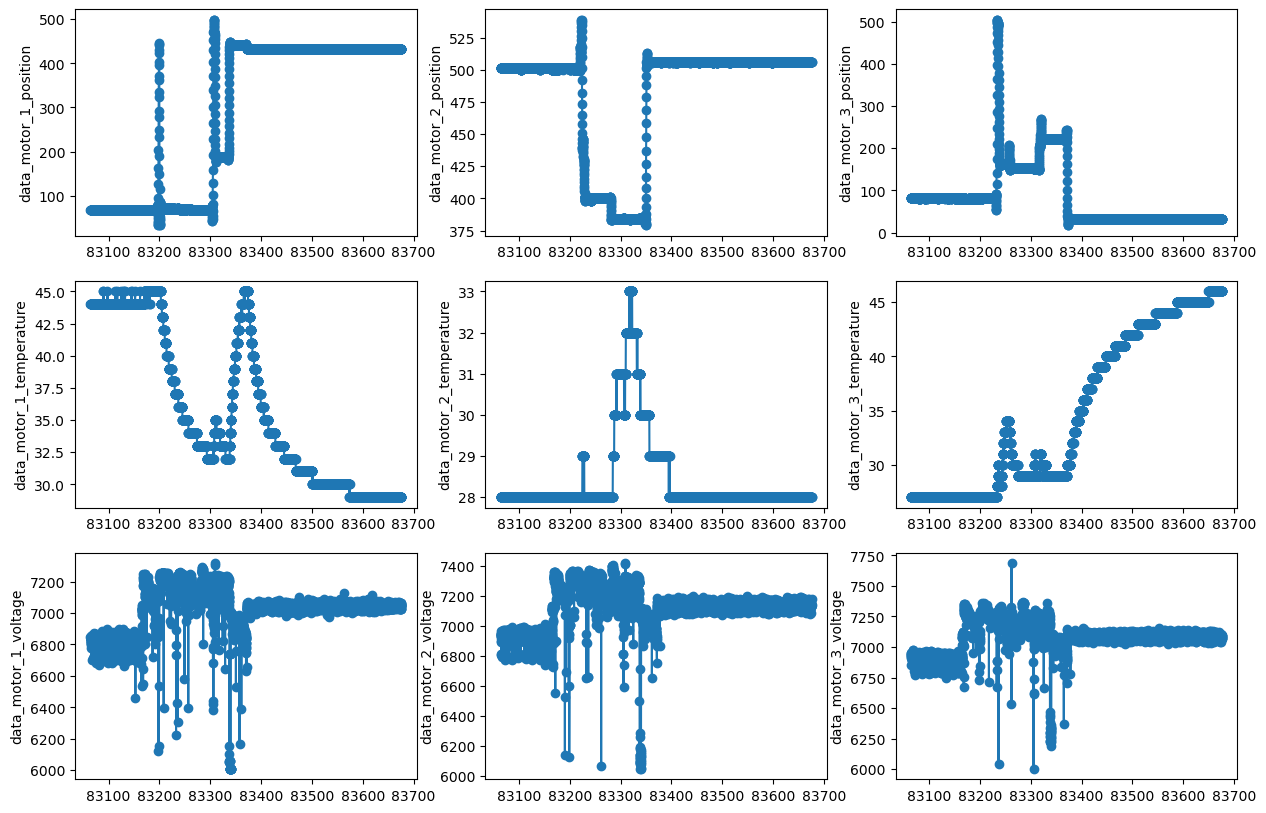

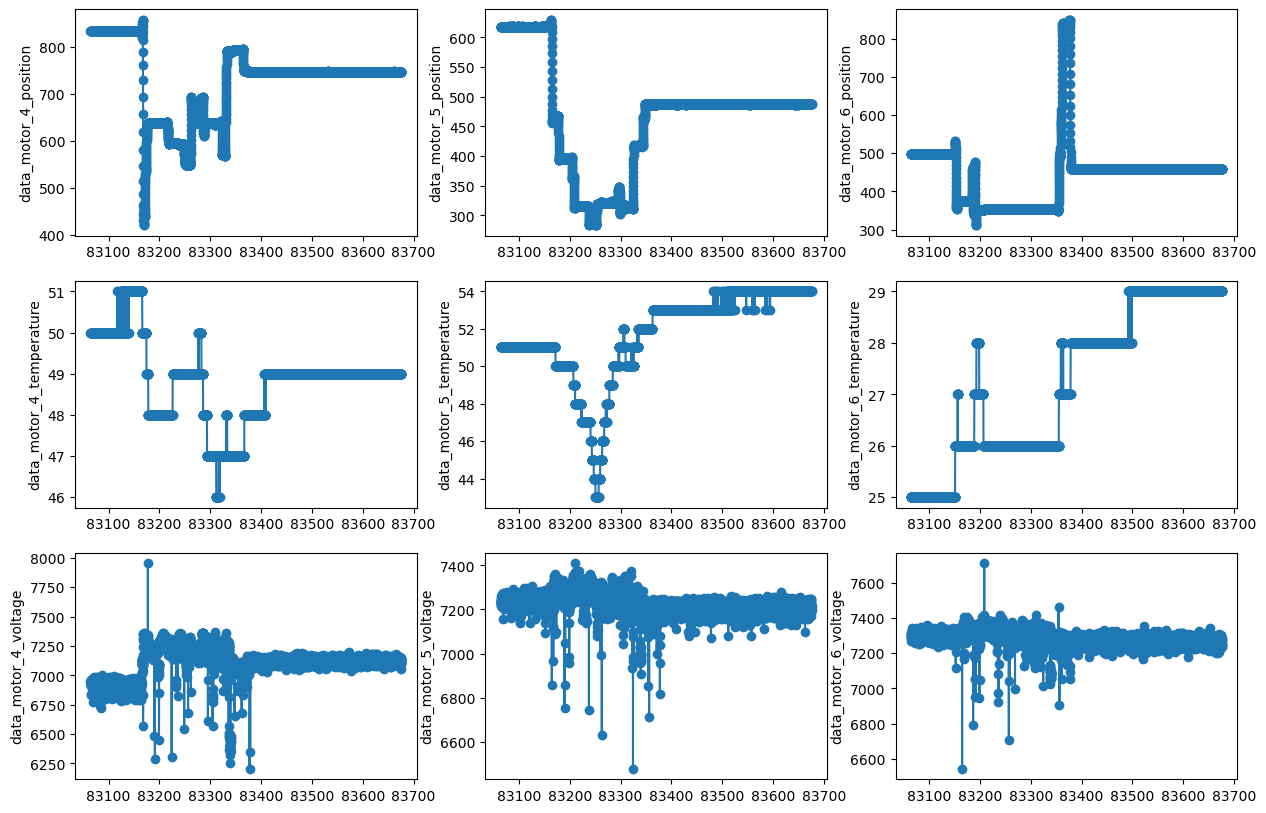

20240325_155003: 9    Starting position: Straigt. Perform two operat...
Name: Description, dtype: object



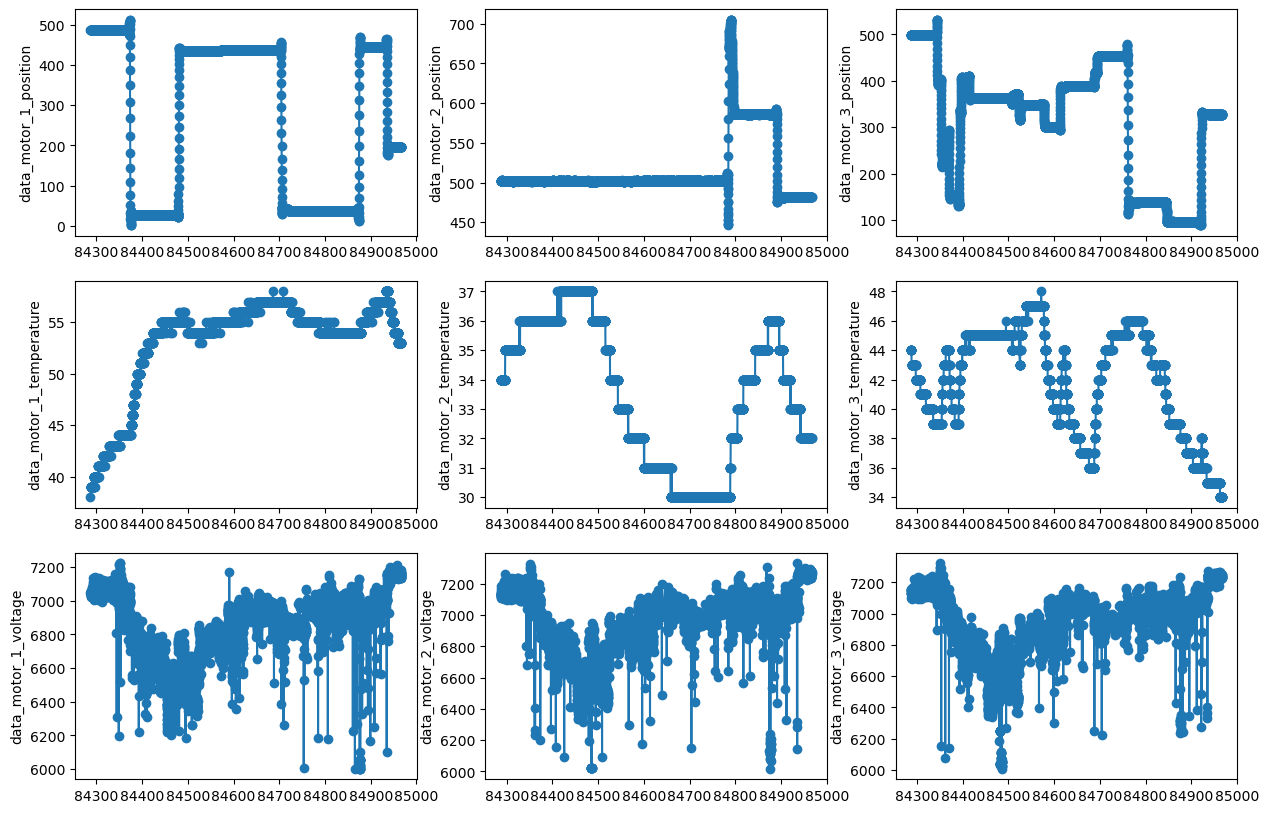

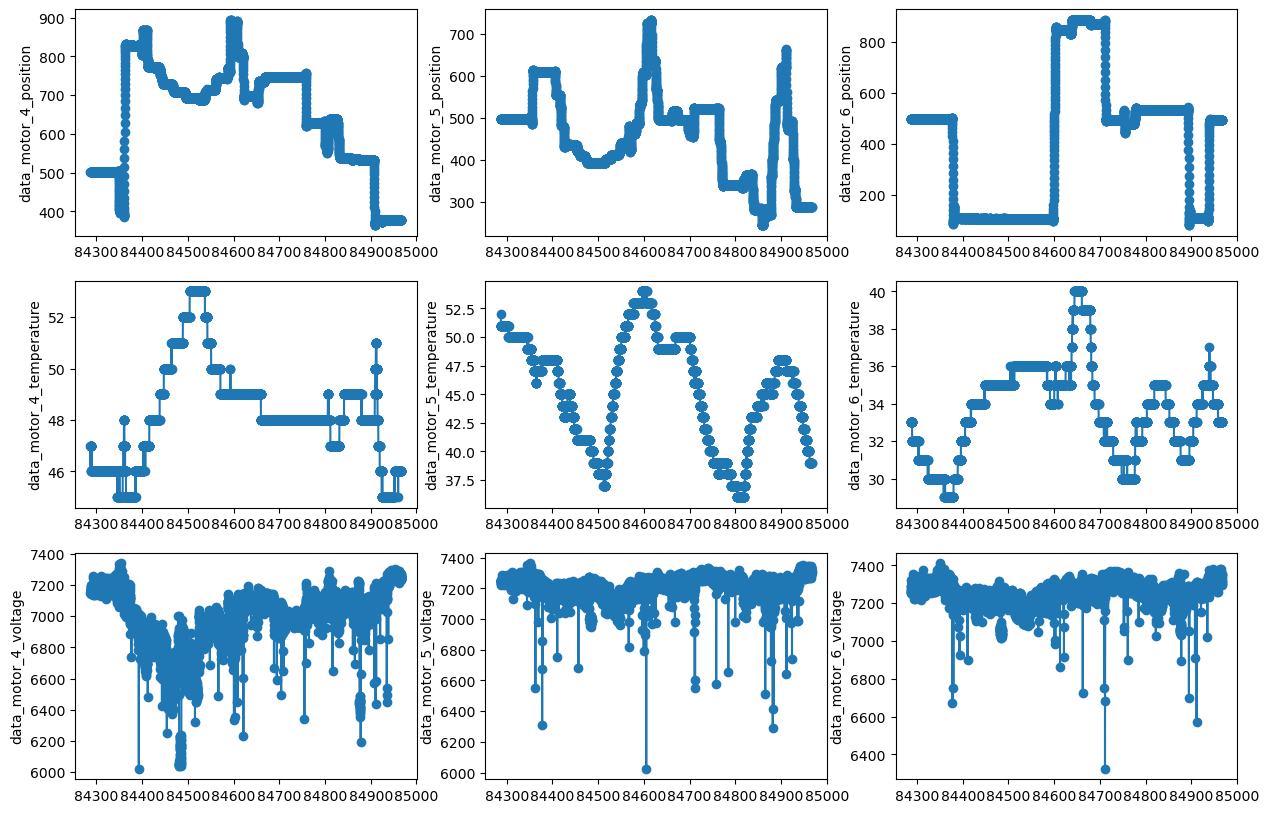

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

base_dictionary = '../../robot_digital_twin/condition_monitoring_matlab_ros/matlab_application/collected_data/'
# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# Visulize the data
for selected_sequence_idx in path_list:
    filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

    print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
        'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
        'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
        ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
        ax.set_ylabel(col)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
        'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
        'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
        ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
        ax.set_ylabel(col)

    plt.show()

## Define experiment supporting function

### Training the model for all motors, using all the features.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from utility import run_cross_val


def run_all_motors(df_data, mdl, window_size=0, single_run_result=True):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        # Get the name of the response variable.
        y_name = f'data_motor_{i}_temperature'
    
        # Seperate features and the response variable.
        # Remove the irrelavent features.
        df_x = df_data.drop(columns=['data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label',
                            'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label'])
        df_x = df_x.drop(columns=[y_name])
        # Get y.
        y = df_data.loc[:, y_name]

        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cross_val(mdl, df_x, y, threshold=3, window_size=window_size, single_run_result=single_run_result)
        # Print the mean performance.
        print(df_perf.mean())
        print('\n')

        all_results.append(df_perf)

    return all_results

### Training the model for all motors, using only the positions.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from utility import run_cross_val


def run_all_motors_reduced_feature(df_data, mdl, window_size=0, single_run_result=True):
    all_results = []
    # Create a list of features that need to be dropped.
    list_dropped_features = []
    for i in range(1, 7):
        list_dropped_features.append(f'data_motor_{i}_label')
        list_dropped_features.append(f'data_motor_{i}_voltage')
        list_dropped_features.append(f'data_motor_{i}_temperature')

    # Loop over all the six motors.
    for i in range(1, 7):
        # Get the name of the response variable.
        y_name = f'data_motor_{i}_temperature'
    
        # Seperate features and the response variable.
        # Remove the irrelavent features.
        df_x = df_data.drop(columns=list_dropped_features)
        # Get y.
        y = df_data.loc[:, y_name]

        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cross_val(mdl, df_x, y, threshold=3, window_size=window_size, single_run_result=single_run_result)
        # Print the mean performance.
        print(df_perf.mean())
        print('\n')

        all_results.append(df_perf)

    return all_results

## Train a linear regression model using a 5-fold cross validation

Then, we run a 5 fold cross validation: Each time, training the model using 8 trajectories while testing on the remaining 2.

### Only removing outliers

In [5]:
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)
all_results = run_all_motors(df_data, pipeline, single_run_result=False)

Model for predicting temperature of motor 1:
Max error               24.550945
RMSE                    10.820579
Exceed boundary rate     0.778400
dtype: float64


Model for predicting temperature of motor 2:
Max error               20.217159
RMSE                    10.737279
Exceed boundary rate     0.705812
dtype: float64


Model for predicting temperature of motor 3:
Max error               16.205448
RMSE                     7.228516
Exceed boundary rate     0.639766
dtype: float64


Model for predicting temperature of motor 4:
Max error               23.236452
RMSE                    10.053387
Exceed boundary rate     0.795095
dtype: float64


Model for predicting temperature of motor 5:
Max error               15.054188
RMSE                     7.605251
Exceed boundary rate     0.599971
dtype: float64


Model for predicting temperature of motor 6:
Max error               9.286007
RMSE                    3.977503
Exceed boundary rate    0.441670
dtype: float64




### Only positions as features

In [6]:
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)
all_results = run_all_motors_reduced_feature(df_data, pipeline, single_run_result=False)

Model for predicting temperature of motor 1:
Max error               25.748237
RMSE                     9.923433
Exceed boundary rate     0.809250
dtype: float64


Model for predicting temperature of motor 2:
Max error               13.632907
RMSE                     6.499166
Exceed boundary rate     0.908318
dtype: float64


Model for predicting temperature of motor 3:
Max error               14.557888
RMSE                     5.625032
Exceed boundary rate     0.508293
dtype: float64


Model for predicting temperature of motor 4:
Max error               24.908656
RMSE                    17.548197
Exceed boundary rate     0.962813
dtype: float64


Model for predicting temperature of motor 5:
Max error               14.090434
RMSE                     5.444348
Exceed boundary rate     0.538509
dtype: float64


Model for predicting temperature of motor 6:
Max error               10.351834
RMSE                     5.695541
Exceed boundary rate     0.611723
dtype: float64




### Smoothing

In [7]:
all_results = run_all_motors(df_data_smoothing, pipeline, single_run_result=False)

Model for predicting temperature of motor 1:
Max error               23.304136
RMSE                    10.764224
Exceed boundary rate     0.773514
dtype: float64


Model for predicting temperature of motor 2:
Max error               17.828530
RMSE                    10.754468
Exceed boundary rate     0.705888
dtype: float64


Model for predicting temperature of motor 3:
Max error               14.395210
RMSE                     7.199784
Exceed boundary rate     0.642052
dtype: float64


Model for predicting temperature of motor 4:
Max error               22.624106
RMSE                    10.075216
Exceed boundary rate     0.795203
dtype: float64


Model for predicting temperature of motor 5:
Max error               14.733136
RMSE                     7.602009
Exceed boundary rate     0.599763
dtype: float64


Model for predicting temperature of motor 6:
Max error               9.308543
RMSE                    3.990020
Exceed boundary rate    0.442851
dtype: float64




## Use a sliding window to predict the next point

In this section, we show a demonstration of how to use a sliding window to predict the next point. We first define a window. Then, the previous points in the window will be used to predict the next point. When the window size shrink to 1, it is equial to the previous model.

### Only removing outliers

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)
all_results = run_all_motors(df_data, pipeline, window_size=3, single_run_result=False)

Model for predicting temperature of motor 1:
Max error               1.117624
RMSE                    0.133048
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 2:
Max error               4.040555
RMSE                    0.196603
Exceed boundary rate    0.000812
dtype: float64


Model for predicting temperature of motor 3:
Max error               0.825046
RMSE                    0.069016
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 4:
Max error               1.017590
RMSE                    0.095306
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 5:
Max error               1.052092
RMSE                    0.137659
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 6:
Max error               1.025290
RMSE                    0.133018
Exceed boundary rate    0.000000
dtype: float64




### Only positions as features

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)
all_results = run_all_motors_reduced_feature(df_data, pipeline, window_size=3, single_run_result=False)

Model for predicting temperature of motor 1:
Max error               1.104391
RMSE                    0.133408
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 2:
Max error               4.010729
RMSE                    0.189515
Exceed boundary rate    0.000812
dtype: float64


Model for predicting temperature of motor 3:
Max error               0.819011
RMSE                    0.068422
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 4:
Max error               1.007746
RMSE                    0.094213
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 5:
Max error               1.024846
RMSE                    0.132315
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 6:
Max error               1.016515
RMSE                    0.132170
Exceed boundary rate    0.000000
dtype: float64




### Smoothing

In [10]:
all_results = run_all_motors(df_data_smoothing, pipeline, window_size=3, single_run_result=False)

Model for predicting temperature of motor 1:
Max error               1.115840
RMSE                    0.133248
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 2:
Max error               1.022171
RMSE                    0.090044
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 3:
Max error               0.825456
RMSE                    0.069185
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 4:
Max error               1.019053
RMSE                    0.095608
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 5:
Max error               1.052307
RMSE                    0.137457
Exceed boundary rate    0.000000
dtype: float64


Model for predicting temperature of motor 6:
Max error               1.025170
RMSE                    0.132769
Exceed boundary rate    0.000000
dtype: float64


